In [668]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

In [669]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/'
protein="TNR" #TNR,Agg,WFA,HABP

In [670]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "endosomechannelno":[],
           "Manual ECM spots mask":[],
           "Manual endosome spots mask":[],
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "2019" in str(filelist[i]):
            if ("posthoc" in str(filelist[i]))==False:
                #if (protein in str(filelist[i]))==True:
                    if filelist[i].endswith(".tif"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i][:-12])
                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                            channeldir="/".join(filelist[i][:-12].split("/")[:-1])
                            exec(open(channeldir+"/channels.txt").read())
                            results["ecmchannelno"].append(ecmchannelno)
                            results["endosomechannelno"].append(endosomechannelno)
                                        

## Loading a random image

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams_Series0_z
Experimental condition: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


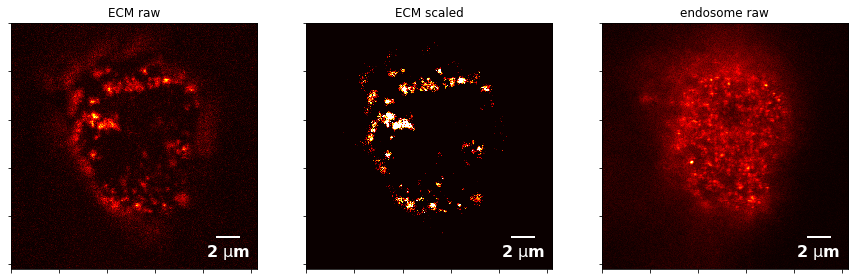

In [671]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]
#synapse_channel_no=results["synapsechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"
#synapse_image_name=results["filename"][randomno]+"0_ch"+str(synapse_channel_no-1)+"_t0.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]
#synapse_image=pims.open(synapse_image_name)[0]
   
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(endosome_image,interpolation='none',cmap='hot')
plt.title('endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## Load manual spots

In [672]:
for image in range(0,len(results["filename"])):
    results["Manual ECM spots mask"].append(np.load(results["filename"][image]+'_ecm_spots_mask.npy'))
    results["Manual endosome spots mask"].append(np.load(results["filename"][image]+'_endosome_spots_mask.npy'))

### Sanity check

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


min distance= 0.5069544212028226, mean dist = 174.44081707143056


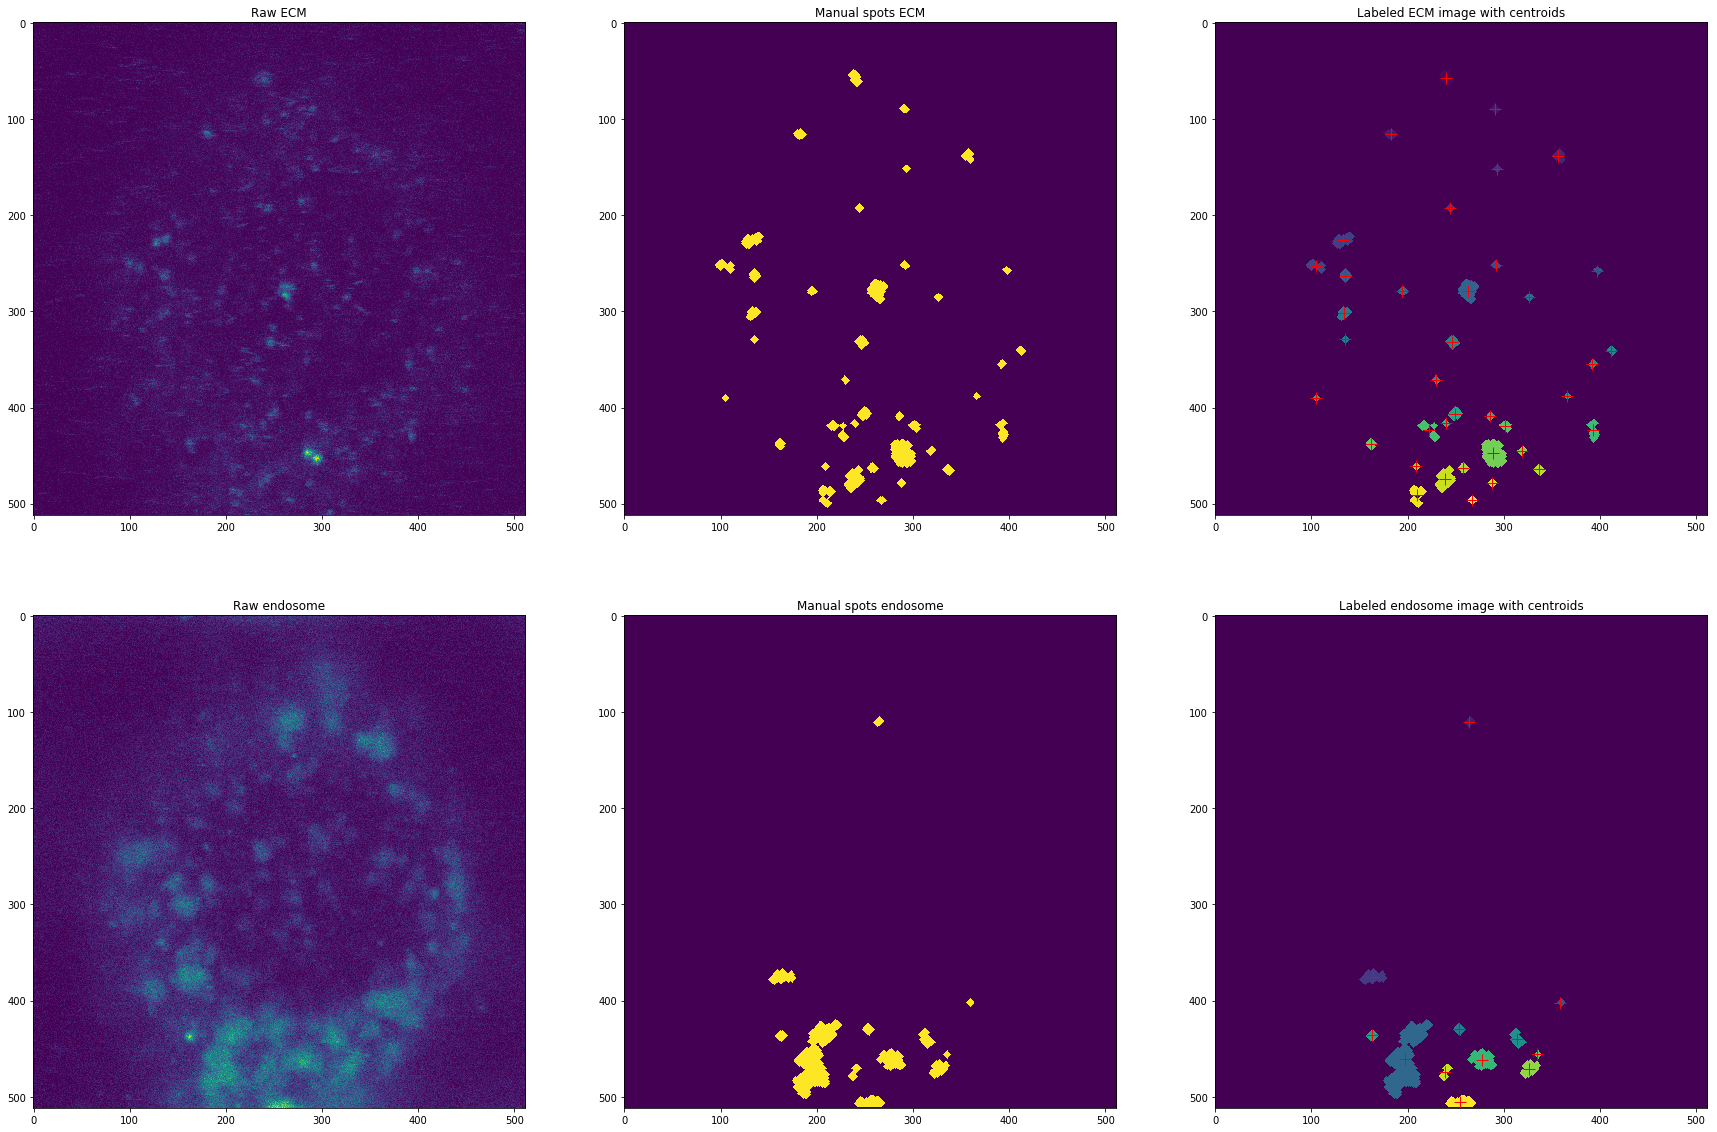

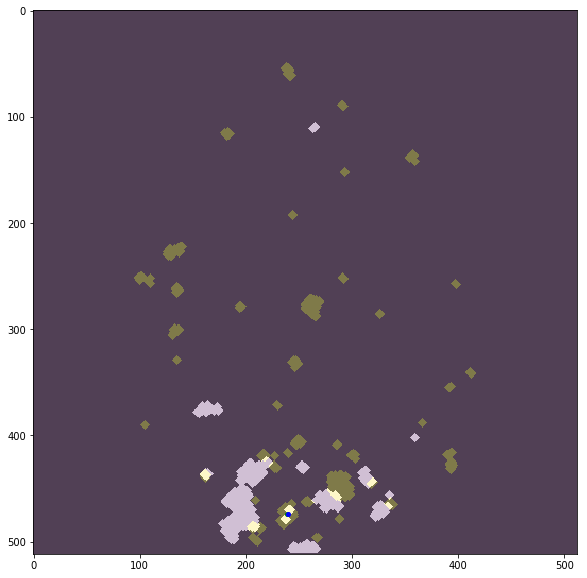

In [589]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]

#read spots masks and label
ecm_mask=results["Manual ECM spots mask"][randomno]
endosome_mask=results["Manual endosome spots mask"][randomno]
labeled_ecm=label(ecm_mask)
labeled_endosome=label(endosome_mask)

regionprops_ecm=regionprops(labeled_ecm)
regionprops_endosome=regionprops(labeled_endosome)

ecm_spots_results_sanity=[]
endosome_spots_results_sanity=[]
for i in range(0,len(regionprops_ecm)):
    ecm_spots_results_sanity.append(regionprops_ecm[i]['centroid'])
for i in range(0,len(regionprops_endosome)):
    endosome_spots_results_sanity.append(regionprops_endosome[i]['centroid'])
    
    
#minimum distance between spots
#ecm
a=scipy.spatial.distance.cdist(ecm_spots_results_sanity,endosome_spots_results_sanity,'euclidean')
b=scipy.spatial.distance.cdist(ecm_spots_results_sanity,endosome_spots_results_sanity,'euclidean').min()
c=np.where(a==b)
nearestecm=ecm_spots_results_sanity[c[0][0]]
nearestendosome=endosome_spots_results_sanity[c[1][0]]
print('min distance= '+str(b)+', mean dist = '+str(a.mean()))
    
fig=plt.figure(figsize=(30,20))
fig.add_subplot(231)
plt.title('Raw ECM')
plt.imshow(ecm_image)
fig.add_subplot(232)
plt.title('Manual spots ECM')
plt.imshow(ecm_mask)
fig.add_subplot(233)
plt.title('Labeled ECM image with centroids')
plt.imshow(labeled_ecm)
for i in range(0,len(ecm_spots_results_sanity)):
    plt.plot(ecm_spots_results_sanity[i][1],ecm_spots_results_sanity[i][0],'+',color='r',markersize=12)

fig.add_subplot(234)
plt.title('Raw endosome')
plt.imshow(endosome_image)
fig.add_subplot(235)
plt.title('Manual spots endosome')
plt.imshow(endosome_mask)
fig.add_subplot(236)
plt.title('Labeled endosome image with centroids')
plt.imshow(labeled_endosome)
for i in range(0,len(endosome_spots_results_sanity)):
    plt.plot(endosome_spots_results_sanity[i][1],endosome_spots_results_sanity[i][0],'+',color='r',markersize=12)
    
newfig=plt.figure(figsize=(10,10))
plt.imshow(ecm_mask,cmap='viridis',alpha=0.5)
plt.imshow(endosome_mask,cmap='gray',alpha=0.5)
plt.plot(nearestecm[1],nearestecm[0],'o',markersize=4,color='g')
plt.plot(nearestendosome[1],nearestendosome[0],'o',markersize=4,color='b')

randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]

#rotate the ecm mask and make another figure########################
ecm_mask=np.rot90(ecm_mask)
labeled_ecm=label(ecm_mask)
labeled_endosome=label(endosome_mask)

regionprops_ecm=regionprops(labeled_ecm)
regionprops_endosome=regionprops(labeled_endosome)

ecm_spots_results_sanity=[]
endosome_spots_results_sanity=[]
for i in range(0,len(regionprops_ecm)):
    ecm_spots_results_sanity.append(regionprops_ecm[i]['centroid'])
for i in range(0,len(regionprops_endosome)):
    endosome_spots_results_sanity.append(regionprops_endosome[i]['centroid'])
    
    
#minimum distance between spots
#ecm
a=scipy.spatial.distance.cdist(ecm_spots_results_sanity,endosome_spots_results_sanity,'euclidean')
b=scipy.spatial.distance.cdist(ecm_spots_results_sanity,endosome_spots_results_sanity,'euclidean').min()
c=np.where(a==b)
nearestecm=ecm_spots_results_sanity[c[0][0]]
nearestendosome=endosome_spots_results_sanity[c[1][0]]
    
fig=plt.figure(figsize=(30,20))
fig.add_subplot(231)
plt.title('Raw ECM')
plt.imshow(ecm_image)
fig.add_subplot(232)
plt.title('Manual spots ECM')
plt.imshow(ecm_mask)
fig.add_subplot(233)
plt.title('Labeled ECM image with centroids')
plt.imshow(labeled_ecm)
for i in range(0,len(ecm_spots_results_sanity)):
    plt.plot(ecm_spots_results_sanity[i][1],ecm_spots_results_sanity[i][0],'+',color='r',markersize=12)

fig.add_subplot(234)
plt.title('Raw endosome')
plt.imshow(endosome_image)
fig.add_subplot(235)
plt.title('Manual spots endosome')
plt.imshow(endosome_mask)
fig.add_subplot(236)
plt.title('Labeled endosome image with centroids')
plt.imshow(labeled_endosome)
for i in range(0,len(endosome_spots_results_sanity)):
    plt.plot(endosome_spots_results_sanity[i][1],endosome_spots_results_sanity[i][0],'+',color='r',markersize=12)
    
newfig=plt.figure(figsize=(10,10))
plt.imshow(ecm_mask,cmap='viridis',alpha=0.5)
plt.imshow(endosome_mask,cmap='gray',alpha=0.5)
plt.plot(nearestecm[1],nearestecm[0],'o',markersize=4,color='g')
plt.plot(nearestendosome[1],nearestendosome[0],'o',markersize=4,color='b')

In [573]:
## distance between boundaries instead of centroids
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]

#read spots masks and label
ecm_mask=results["Manual ECM spots mask"][randomno]
endosome_mask=results["Manual endosome spots mask"][randomno]
labeled_ecm=label(ecm_mask)
labeled_endosome=label(endosome_mask)

regionprops_ecm=regionprops(labeled_ecm)
regionprops_endosome=regionprops(labeled_endosome)

ecm_spots_results_sanity=[]
endosome_spots_results_sanity=[]
for i in range(0,len(regionprops_ecm)):
    ecm_spots_results_sanity.append(regionprops_ecm[i]['centroid'])
for i in range(0,len(regionprops_endosome)):
    endosome_spots_results_sanity.append(regionprops_endosome[i]['coords'][0])
    
    
#minimum distance between spots
#ecm
if 
a=scipy.spatial.distance.cdist(ecm_spots_results_sanity,endosome_spots_results_sanity,'euclidean')
b=scipy.spatial.distance.cdist(ecm_spots_results_sanity,endosome_spots_results_sanity,'euclidean').min()
c=np.where(a==b)
nearestecm=ecm_spots_results_sanity[c[0][0]]
nearestendosome=endosome_spots_results_sanity[c[1][0]]
print('min distance= '+str(b)+', mean dist = '+str(a.mean()))
    
fig=plt.figure(figsize=(30,20))
fig.add_subplot(231)
plt.title('Raw ECM')
plt.imshow(ecm_image)
fig.add_subplot(232)
plt.title('Manual spots ECM')
plt.imshow(ecm_mask)
fig.add_subplot(233)
plt.title('Labeled ECM image with centroids')
plt.imshow(labeled_ecm)
for i in range(0,len(ecm_spots_results_sanity)):
    plt.plot(ecm_spots_results_sanity[i][1],ecm_spots_results_sanity[i][0],'+',color='r',markersize=12)

fig.add_subplot(234)
plt.title('Raw endosome')
plt.imshow(endosome_image)
fig.add_subplot(235)
plt.title('Manual spots endosome')
plt.imshow(endosome_mask)
fig.add_subplot(236)
plt.title('Labeled endosome image with centroids')
plt.imshow(labeled_endosome)
for i in range(0,len(endosome_spots_results_sanity)):
    plt.plot(endosome_spots_results_sanity[i][1],endosome_spots_results_sanity[i][0],'+',color='r',markersize=12)
    
newfig=plt.figure(figsize=(10,10))
plt.imshow(ecm_mask,cmap='viridis',alpha=0.5)
plt.imshow(endosome_mask,cmap='gray',alpha=0.5)
plt.plot(nearestecm[1],nearestecm[0],'o',markersize=4,color='g')
plt.plot(nearestendosome[1],nearestendosome[0],'o',markersize=4,color='b')

SyntaxError: invalid syntax (<ipython-input-573-6efa47246c18>, line 31)

## Batch analysis on spots

### Dictionary of spot regionprops

In [590]:
## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest endosome centroid":[],
                 "distance to nearest endosome centroid [nms]":[]
                  }
endosome_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                       "distance to nearest ecm centroid [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    ecm_channel_no=results["ecmchannelno"][image]
    endosome_channel_no=results["endosomechannelno"][image]

    ecm_image_name=results["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=results["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

    print("Image name:",results["filename"][image].split('/')[-1])
    print("Experimental condition:",results["exp condition"][image])
    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]
    
    #read spots masks and label
    ecm_mask=results["Manual ECM spots mask"][image]
    endosome_mask=results["Manual endosome spots mask"][image]
    labeled_ecm=label(ecm_mask)
    labeled_endosome=label(endosome_mask)
    
    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_endosome=regionprops(labeled_endosome)

    for i in range(0,len(regionprops_ecm)):
        ecm_spots_results["filename"].append(results["filename"][image])
        ecm_spots_results["exp condition"].append(results["exp condition"][image])
        ecm_spots_results["spotno"].append(i)
        ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'])
        ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_endosome)):
        endosome_spots_results["filename"].append(results["filename"][image])
        endosome_spots_results["exp condition"].append(results["exp condition"][image])
        endosome_spots_results["spotno"].append(i)
        endosome_spots_results["centroid"].append(regionprops_endosome[i]['centroid'])
        endosome_spots_results["size"].append(regionprops_endosome[i]['area'])
    

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 1 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series8_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 2 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series9_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 3 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series0_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 4 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series1_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 5 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series2_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 6 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series3_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 7 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series4_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 8 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series5_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 9 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series6_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


KeyboardInterrupt: 

## with boundaries instead of centroids

In [640]:
## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest endosome centroid":[],
                 "distance to nearest endosome centroid [nms]":[]
                  }
endosome_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                       "distance to nearest ecm centroid [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    ecm_channel_no=results["ecmchannelno"][image]
    endosome_channel_no=results["endosomechannelno"][image]

    ecm_image_name=results["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=results["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

    print("Image name:",results["filename"][image].split('/')[-1])
    print("Experimental condition:",results["exp condition"][image])
    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]
    
    #read spots masks and label
    ecm_mask=results["Manual ECM spots mask"][image]
    endosome_mask=results["Manual endosome spots mask"][image]
    labeled_ecm=label(ecm_mask)
    labeled_endosome=label(endosome_mask)
    
    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_endosome=regionprops(labeled_endosome)

    for i in range(0,len(regionprops_ecm)):
        ecm_spots_results["filename"].append(results["filename"][image])
        ecm_spots_results["exp condition"].append(results["exp condition"][image])
        ecm_spots_results["spotno"].append(i)
        ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'])
        ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_endosome)):
        endosome_spots_results["filename"].append(results["filename"][image])
        endosome_spots_results["exp condition"].append(results["exp condition"][image])
        endosome_spots_results["spotno"].append(i)
        endosome_spots_results["centroid"].append(regionprops_endosome[i]['coords'][0])
        endosome_spots_results["size"].append(regionprops_endosome[i]['area'])
    

Calculating image no 1 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series8_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 2 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series9_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 3 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series0_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 4 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series1_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 5 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series2_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 6 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series3_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 7 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series4_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 8 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series5_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 9 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series6_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 10 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series7_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 11 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series9_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 12 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series8_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 13 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series7_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 14 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series6_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 15 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series5_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 16 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series4_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 17 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series3_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 18 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series2_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 19 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series1_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped
Calculating image no 20 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series12_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 21 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series11_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 22 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series10_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 23 out of168
Image name: 20190523_tnr550_intfitc_blockedplus12_stripped_Series0_z
Experimental condition: 20190523_tnr550_intfitc_blockedplus12_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 24 out of168
Image name: 20190605_tnr647blockplus12_int1fitc_contactincy3_Series5_z
Experimental condition: 20190605_tnr647blockplus12_int1fitc_contactincy3


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 25 out of168
Image name: 20190605_tnr647blockplus12_int1fitc_contactincy3_Series4_z
Experimental condition: 20190605_tnr647blockplus12_int1fitc_contactincy3


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 26 out of168
Image name: 20190605_tnr647blockplus12_int1fitc_contactincy3_Series3_z
Experimental condition: 20190605_tnr647blockplus12_int1fitc_contactincy3


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 27 out of168
Image name: 20190605_tnr647blockplus12_int1fitc_contactincy3_Series2_z
Experimental condition: 20190605_tnr647blockplus12_int1fitc_contactincy3


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 28 out of168
Image name: 20190605_tnr647blockplus12_int1fitc_contactincy3_Series1_z
Experimental condition: 20190605_tnr647blockplus12_int1fitc_contactincy3
Calculating image no 29 out of168
Image name: 20190605_tnr647blockplus12_int1fitc_contactincy3_Series0_z
Experimental condition: 20190605_tnr647blockplus12_int1fitc_contactincy3


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 30 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_Series7_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 31 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_Series6_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 32 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_Series5_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 33 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_Series4_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 34 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_Series3_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 35 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_Series2_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 36 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_Series1_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 37 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_Series0_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 38 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34_Series9_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 39 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34_Series8_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 40 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34_Series7_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 41 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34_Series6_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 42 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34_Series5_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 43 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34_Series4_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 44 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34_Series3_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 45 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34_Series2_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 46 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34_Series1_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 47 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34_Series10_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 48 out of168
Image name: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34_Series0_z
Experimental condition: 20190515_TNR550_Int1beta_stripped_plus12hr_cs34


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 49 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series8_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 50 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series7_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 51 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series6_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 52 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series5_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 53 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series4_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 54 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series3_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 55 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series2_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 56 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series1_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 57 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series0_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 58 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series9_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 59 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series8_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 60 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series7_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 61 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series6_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 62 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series5_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 63 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series4_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 64 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series3_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 65 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series2_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 66 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series1_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 67 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series10_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file


Calculating image no 68 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series0_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2


TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 69 out of168
Image name: 20190612_tnr647_blkplus12_tgn38acy2_Series9_z
Experimental condition: 20190612_tnr647_blkplus12_tgn38acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 70 out of168
Image name: 20190612_tnr647_blkplus12_tgn38acy2_Series8_z
Experimental condition: 20190612_tnr647_blkplus12_tgn38acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 71 out of168
Image name: 20190612_tnr647_blkplus12_tgn38acy2_Series7_z
Experimental condition: 20190612_tnr647_blkplus12_tgn38acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 72 out of168
Image name: 20190612_tnr647_blkplus12_tgn38acy2_Series6_z
Experimental condition: 20190612_tnr647_blkplus12_tgn38acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 73 out of168
Image name: 20190612_tnr647_blkplus12_tgn38acy2_Series5_z
Experimental condition: 20190612_tnr647_blkplus12_tgn38acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 74 out of168
Image name: 20190612_tnr647_blkplus12_tgn38acy2_Series4_z
Experimental condition: 20190612_tnr647_blkplus12_tgn38acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 75 out of168
Image name: 20190612_tnr647_blkplus12_tgn38acy2_Series3_z
Experimental condition: 20190612_tnr647_blkplus12_tgn38acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 76 out of168
Image name: 20190612_tnr647_blkplus12_tgn38acy2_Series2_z
Experimental condition: 20190612_tnr647_blkplus12_tgn38acy2
Calculating image no 77 out of168
Image name: 20190612_tnr647_blkplus12_tgn38acy2_Series1_z
Experimental condition: 20190612_tnr647_blkplus12_tgn38acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 78 out of168
Image name: 20190612_tnr647_blkplus12_tgn38acy2_Series0_z
Experimental condition: 20190612_tnr647_blkplus12_tgn38acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 79 out of168
Image name: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked_Series9_z
Experimental condition: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 80 out of168
Image name: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked_Series8_z
Experimental condition: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 81 out of168
Image name: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked_Series7_z
Experimental condition: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 82 out of168
Image name: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked_Series6_z
Experimental condition: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Calculating image no 83 out of168
Image name: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked_Series5_z
Experimental condition: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Calculating image no 84 out of168
Image name: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked_Series4_z
Experimental condition: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Calculating image no 85 out of168
Image name: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked_Series3_z
Experimental condition: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Calculating image no 86 out of168
Image name: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked_Series2_z
Experimental condition: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Calculating image no 87 out of168
Image name: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked_Series1_z
Experimental condition: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Calculating image no 88 out of168
Image name: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked_Series0_z
Experimental condition: 20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 89 out of168
Image name: 20190605_tnr647blockplus12_rab11acy2_Series4_z
Experimental condition: 20190605_tnr647blockplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 90 out of168
Image name: 20190605_tnr647blockplus12_rab11acy2_Series3_z
Experimental condition: 20190605_tnr647blockplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 91 out of168
Image name: 20190605_tnr647blockplus12_rab11acy2_Series2_z
Experimental condition: 20190605_tnr647blockplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 92 out of168
Image name: 20190605_tnr647blockplus12_rab11acy2_Series1_z
Experimental condition: 20190605_tnr647blockplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 93 out of168
Image name: 20190605_tnr647blockplus12_rab11acy2_Series0_z
Experimental condition: 20190605_tnr647blockplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 94 out of168
Image name: 20190515_TNR550_Int1beta_bothblocked_plus0h_Series9_z
Experimental condition: 20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 95 out of168
Image name: 20190515_TNR550_Int1beta_bothblocked_plus0h_Series8_z
Experimental condition: 20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 96 out of168
Image name: 20190515_TNR550_Int1beta_bothblocked_plus0h_Series6_z
Experimental condition: 20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 97 out of168
Image name: 20190515_TNR550_Int1beta_bothblocked_plus0h_Series5_z
Experimental condition: 20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 98 out of168
Image name: 20190515_TNR550_Int1beta_bothblocked_plus0h_Series4_z
Experimental condition: 20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 99 out of168
Image name: 20190515_TNR550_Int1beta_bothblocked_plus0h_Series3_z
Experimental condition: 20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 100 out of168
Image name: 20190515_TNR550_Int1beta_bothblocked_plus0h_Series2_z
Experimental condition: 20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 101 out of168
Image name: 20190515_TNR550_Int1beta_bothblocked_plus0h_Series1_z
Experimental condition: 20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 102 out of168
Image name: 20190515_TNR550_Int1beta_bothblocked_plus0h_Series0_z
Experimental condition: 20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 103 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series9_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 104 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series8_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 105 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series7_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 106 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series6_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 107 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series5_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 108 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series4_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file


Calculating image no 109 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series3_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 110 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series2_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 111 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series1_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 112 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series13_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 113 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series12_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 114 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series11_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 115 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series10_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 116 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series0_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 117 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series7_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 118 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series6_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 119 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series5_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 120 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series4_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 121 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series3_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 122 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series2_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 123 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series1_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 124 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series0_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 125 out of168
Image name: 20190611_tnr550_blkplus0_int1fitcblk_ctc1amca_vglut635p_onlysurface_Series7_z
Experimental condition: 20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 126 out of168
Image name: 20190611_tnr550_blkplus0_int1fitcblk_ctc1amca_vglut635p_onlysurface_Series6_z
Experimental condition: 20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 127 out of168
Image name: 20190611_tnr550_blkplus0_int1fitcblk_ctc1amca_vglut635p_onlysurface_Series5_z
Experimental condition: 20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse
Calculating image no 128 out of168
Image name: 20190611_tnr550_blkplus0_int1fitcblk_ctc1amca_vglut635p_onlysurface_Series4_z
Experimental condition: 20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 129 out of168
Image name: 20190611_tnr550_blkplus0_int1fitcblk_ctc1amca_vglut635p_onlysurface_Series3_z
Experimental condition: 20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 130 out of168
Image name: 20190611_tnr550_blkplus0_int1fitcblk_ctc1amca_vglut635p_onlysurface_Series2_z
Experimental condition: 20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 131 out of168
Image name: 20190611_tnr550_blkplus0_int1fitcblk_ctc1amca_vglut635p_onlysurface_Series1_z
Experimental condition: 20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 132 out of168
Image name: 20190611_tnr550_blkplus0_int1fitcblk_ctc1amca_vglut635p_onlysurface_Series0_z
Experimental condition: 20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file


Calculating image no 133 out of168
Image name: 20190505_tnr550_blkplus0_postliveexp_cav1cy2_goodparams_Series3_z
Experimental condition: 20190505_tnr550_blkplus0_postliveexp_cav1cy2_goodparams


TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 134 out of168
Image name: 20190505_tnr550_blkplus0_postliveexp_cav1cy2_goodparams_Series2_z
Experimental condition: 20190505_tnr550_blkplus0_postliveexp_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 135 out of168
Image name: 20190505_tnr550_blkplus0_postliveexp_cav1cy2_goodparams_Series1_z
Experimental condition: 20190505_tnr550_blkplus0_postliveexp_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 136 out of168
Image name: 20190505_tnr550_blkplus0_postliveexp_cav1cy2_goodparams_Series0_z
Experimental condition: 20190505_tnr550_blkplus0_postliveexp_cav1cy2_goodparams
Calculating image no 137 out of168
Image name: 20190522_tnr550_blkplus2_cav1cy2_goodparams_Series7_z
Experimental condition: 20190522_tnr550_blkplus2_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 138 out of168
Image name: 20190522_tnr550_blkplus2_cav1cy2_goodparams_Series6_z
Experimental condition: 20190522_tnr550_blkplus2_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 139 out of168
Image name: 20190522_tnr550_blkplus2_cav1cy2_goodparams_Series5_z
Experimental condition: 20190522_tnr550_blkplus2_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 140 out of168
Image name: 20190522_tnr550_blkplus2_cav1cy2_goodparams_Series4_z
Experimental condition: 20190522_tnr550_blkplus2_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 141 out of168
Image name: 20190522_tnr550_blkplus2_cav1cy2_goodparams_Series3_z
Experimental condition: 20190522_tnr550_blkplus2_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 142 out of168
Image name: 20190522_tnr550_blkplus2_cav1cy2_goodparams_Series2_z
Experimental condition: 20190522_tnr550_blkplus2_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 143 out of168
Image name: 20190522_tnr550_blkplus2_cav1cy2_goodparams_Series1_z
Experimental condition: 20190522_tnr550_blkplus2_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 144 out of168
Image name: 20190522_tnr550_blkplus2_cav1cy2_goodparams_Series0_z
Experimental condition: 20190522_tnr550_blkplus2_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 145 out of168
Image name: 20190522_tnr550_blkplus20min_cav1cy2_goodparams_Series8_z
Experimental condition: 20190522_tnr550_blkplus20min_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 146 out of168
Image name: 20190522_tnr550_blkplus20min_cav1cy2_goodparams_Series7_z
Experimental condition: 20190522_tnr550_blkplus20min_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 147 out of168
Image name: 20190522_tnr550_blkplus20min_cav1cy2_goodparams_Series6_z
Experimental condition: 20190522_tnr550_blkplus20min_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 148 out of168
Image name: 20190522_tnr550_blkplus20min_cav1cy2_goodparams_Series5_z
Experimental condition: 20190522_tnr550_blkplus20min_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 149 out of168
Image name: 20190522_tnr550_blkplus20min_cav1cy2_goodparams_Series4_z
Experimental condition: 20190522_tnr550_blkplus20min_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 150 out of168
Image name: 20190522_tnr550_blkplus20min_cav1cy2_goodparams_Series3_z
Experimental condition: 20190522_tnr550_blkplus20min_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 151 out of168
Image name: 20190522_tnr550_blkplus20min_cav1cy2_goodparams_Series2_z
Experimental condition: 20190522_tnr550_blkplus20min_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 152 out of168
Image name: 20190522_tnr550_blkplus20min_cav1cy2_goodparams_Series1_z
Experimental condition: 20190522_tnr550_blkplus20min_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 153 out of168
Image name: 20190522_tnr550_blkplus20min_cav1cy2_goodparams_Series0_z
Experimental condition: 20190522_tnr550_blkplus20min_cav1cy2_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 154 out of168
Image name: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams_Series4_z
Experimental condition: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file


Calculating image no 155 out of168
Image name: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams_Series3_z
Experimental condition: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams


TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 156 out of168
Image name: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams_Series2_z
Experimental condition: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 157 out of168
Image name: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams_Series1_z
Experimental condition: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 158 out of168
Image name: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams_Series0_z
Experimental condition: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 159 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series9_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 160 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series8_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 161 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series7_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 162 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series6_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 163 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series5_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 164 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series4_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 165 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series3_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 166 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series2_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 167 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series1_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Calculating image no 168 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series0_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2


In [592]:
results["Manual ECM spots mask"][image]=results["Manual ECM spots mask"][image-1]
results["Manual endosome spots mask"][image]=results["Manual endosome spots mask"][image-1]

### Find the min distances between spots

In [663]:
for i in range(0,len(ecm_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(ecm_spots_results["filename"])))
    
    flaginside=False
    for element in range(0,len(endosome_spots_results["centroid"])):
        if (np.round(ecm_spots_results["centroid"][i]).astype(int)[0] == endosome_spots_results["centroid"][element][0])&(np.round(ecm_spots_results["centroid"][i]).astype(int)[1] == endosome_spots_results["centroid"][element][1]):

            flaginside=True
            print('this is 0')
            break
    if flaginside==True:
        ecm_spots_results["distance to nearest endosome centroid"].append(0)
        ecm_spots_results["distance to nearest endosome centroid [nms]"].append(0)
    else:
        ecm_spots_results["distance to nearest endosome centroid"].append(scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                         endosome_spots_results["centroid"],'euclidean').min())
        ecm_spots_results["distance to nearest endosome centroid [nms]"].append(scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                         endosome_spots_results["centroid"],'euclidean').min()*40.6)

'''for i in range(0,len(endosome_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(endosome_spots_results["filename"])))
    
    for element in range(0,len(endosome_spots_results["centroid"])):
        if np.round(endosome_spots_results["centroid"][i]).astype(int) in ecm_spots_results["centroid"][element]:
            flaginside=True
            break
        if flaginside==True:
            endosome_spots_results["distance to nearest ecm centroid"].append(0)
        else:
    
    
            endosome_spots_results["distance to nearest ecm centroid"].append(
                scipy.spatial.distance.cdist([endosome_spots_results["centroid"][i]],
                                             ecm_spots_results["centroid"],'euclidean').min())
    
                                     
    endosome_spots_results["distance to nearest ecm centroid [nms]"].append(
        scipy.spatial.distance.cdist([endosome_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min()*40.6)'''


1 out of 6354
2 out of 6354
3 out of 6354
4 out of 6354
5 out of 6354
6 out of 6354
7 out of 6354
8 out of 6354
9 out of 6354
10 out of 6354
11 out of 6354
12 out of 6354
13 out of 6354
14 out of 6354
15 out of 6354
16 out of 6354
17 out of 6354
18 out of 6354
19 out of 6354
20 out of 6354
21 out of 6354
22 out of 6354
23 out of 6354
24 out of 6354
25 out of 6354
26 out of 6354
27 out of 6354
28 out of 6354
29 out of 6354
30 out of 6354
31 out of 6354
32 out of 6354
33 out of 6354
34 out of 6354
35 out of 6354
36 out of 6354
37 out of 6354
38 out of 6354
39 out of 6354
40 out of 6354
41 out of 6354
42 out of 6354
43 out of 6354
44 out of 6354
45 out of 6354
46 out of 6354
47 out of 6354
48 out of 6354
49 out of 6354
50 out of 6354
51 out of 6354
52 out of 6354
53 out of 6354
54 out of 6354
55 out of 6354
56 out of 6354
57 out of 6354
58 out of 6354
59 out of 6354
60 out of 6354
61 out of 6354
62 out of 6354
63 out of 6354
64 out of 6354
65 out of 6354
66 out of 6354
67 out of 6354
68 o

517 out of 6354
518 out of 6354
519 out of 6354
520 out of 6354
521 out of 6354
522 out of 6354
523 out of 6354
524 out of 6354
525 out of 6354
526 out of 6354
527 out of 6354
528 out of 6354
529 out of 6354
530 out of 6354
531 out of 6354
532 out of 6354
533 out of 6354
534 out of 6354
535 out of 6354
536 out of 6354
537 out of 6354
538 out of 6354
this is 0
539 out of 6354
540 out of 6354
541 out of 6354
542 out of 6354
543 out of 6354
544 out of 6354
this is 0
545 out of 6354
546 out of 6354
547 out of 6354
548 out of 6354
549 out of 6354
550 out of 6354
551 out of 6354
552 out of 6354
553 out of 6354
554 out of 6354
555 out of 6354
556 out of 6354
557 out of 6354
558 out of 6354
559 out of 6354
560 out of 6354
561 out of 6354
562 out of 6354
563 out of 6354
564 out of 6354
565 out of 6354
566 out of 6354
567 out of 6354
568 out of 6354
569 out of 6354
570 out of 6354
571 out of 6354
572 out of 6354
573 out of 6354
574 out of 6354
575 out of 6354
576 out of 6354
577 out of 6354
578 

1023 out of 6354
1024 out of 6354
1025 out of 6354
1026 out of 6354
1027 out of 6354
1028 out of 6354
1029 out of 6354
1030 out of 6354
1031 out of 6354
1032 out of 6354
1033 out of 6354
1034 out of 6354
1035 out of 6354
1036 out of 6354
1037 out of 6354
1038 out of 6354
1039 out of 6354
1040 out of 6354
1041 out of 6354
1042 out of 6354
this is 0
1043 out of 6354
1044 out of 6354
1045 out of 6354
1046 out of 6354
1047 out of 6354
1048 out of 6354
1049 out of 6354
this is 0
1050 out of 6354
1051 out of 6354
1052 out of 6354
1053 out of 6354
1054 out of 6354
1055 out of 6354
1056 out of 6354
1057 out of 6354
1058 out of 6354
1059 out of 6354
1060 out of 6354
1061 out of 6354
1062 out of 6354
1063 out of 6354
1064 out of 6354
1065 out of 6354
1066 out of 6354
1067 out of 6354
1068 out of 6354
1069 out of 6354
1070 out of 6354
1071 out of 6354
1072 out of 6354
1073 out of 6354
1074 out of 6354
1075 out of 6354
1076 out of 6354
1077 out of 6354
1078 out of 6354
1079 out of 6354
1080 out of

1502 out of 6354
1503 out of 6354
1504 out of 6354
1505 out of 6354
1506 out of 6354
1507 out of 6354
1508 out of 6354
1509 out of 6354
1510 out of 6354
1511 out of 6354
this is 0
1512 out of 6354
1513 out of 6354
1514 out of 6354
1515 out of 6354
this is 0
1516 out of 6354
1517 out of 6354
1518 out of 6354
1519 out of 6354
1520 out of 6354
1521 out of 6354
1522 out of 6354
1523 out of 6354
1524 out of 6354
1525 out of 6354
this is 0
1526 out of 6354
1527 out of 6354
1528 out of 6354
1529 out of 6354
1530 out of 6354
1531 out of 6354
1532 out of 6354
1533 out of 6354
1534 out of 6354
1535 out of 6354
1536 out of 6354
1537 out of 6354
1538 out of 6354
1539 out of 6354
1540 out of 6354
1541 out of 6354
1542 out of 6354
1543 out of 6354
1544 out of 6354
1545 out of 6354
1546 out of 6354
1547 out of 6354
1548 out of 6354
1549 out of 6354
1550 out of 6354
1551 out of 6354
1552 out of 6354
1553 out of 6354
1554 out of 6354
1555 out of 6354
1556 out of 6354
1557 out of 6354
1558 out of 6354
1

1980 out of 6354
1981 out of 6354
1982 out of 6354
this is 0
1983 out of 6354
1984 out of 6354
1985 out of 6354
1986 out of 6354
this is 0
1987 out of 6354
1988 out of 6354
1989 out of 6354
1990 out of 6354
1991 out of 6354
1992 out of 6354
1993 out of 6354
1994 out of 6354
1995 out of 6354
1996 out of 6354
1997 out of 6354
1998 out of 6354
1999 out of 6354
2000 out of 6354
2001 out of 6354
2002 out of 6354
2003 out of 6354
2004 out of 6354
2005 out of 6354
2006 out of 6354
2007 out of 6354
2008 out of 6354
2009 out of 6354
2010 out of 6354
2011 out of 6354
2012 out of 6354
2013 out of 6354
2014 out of 6354
2015 out of 6354
2016 out of 6354
2017 out of 6354
2018 out of 6354
2019 out of 6354
2020 out of 6354
2021 out of 6354
2022 out of 6354
2023 out of 6354
2024 out of 6354
2025 out of 6354
2026 out of 6354
2027 out of 6354
2028 out of 6354
2029 out of 6354
2030 out of 6354
2031 out of 6354
2032 out of 6354
2033 out of 6354
2034 out of 6354
2035 out of 6354
2036 out of 6354
2037 out of

2457 out of 6354
2458 out of 6354
2459 out of 6354
2460 out of 6354
2461 out of 6354
2462 out of 6354
2463 out of 6354
2464 out of 6354
2465 out of 6354
2466 out of 6354
2467 out of 6354
2468 out of 6354
2469 out of 6354
2470 out of 6354
2471 out of 6354
2472 out of 6354
2473 out of 6354
2474 out of 6354
2475 out of 6354
2476 out of 6354
2477 out of 6354
2478 out of 6354
2479 out of 6354
2480 out of 6354
2481 out of 6354
2482 out of 6354
2483 out of 6354
2484 out of 6354
2485 out of 6354
2486 out of 6354
2487 out of 6354
2488 out of 6354
this is 0
2489 out of 6354
2490 out of 6354
2491 out of 6354
2492 out of 6354
2493 out of 6354
2494 out of 6354
2495 out of 6354
2496 out of 6354
2497 out of 6354
2498 out of 6354
2499 out of 6354
2500 out of 6354
2501 out of 6354
2502 out of 6354
2503 out of 6354
2504 out of 6354
2505 out of 6354
2506 out of 6354
2507 out of 6354
2508 out of 6354
2509 out of 6354
2510 out of 6354
2511 out of 6354
2512 out of 6354
2513 out of 6354
2514 out of 6354
2515

2931 out of 6354
2932 out of 6354
2933 out of 6354
this is 0
2934 out of 6354
2935 out of 6354
2936 out of 6354
2937 out of 6354
2938 out of 6354
2939 out of 6354
2940 out of 6354
2941 out of 6354
2942 out of 6354
2943 out of 6354
2944 out of 6354
2945 out of 6354
2946 out of 6354
2947 out of 6354
2948 out of 6354
2949 out of 6354
2950 out of 6354
2951 out of 6354
2952 out of 6354
2953 out of 6354
2954 out of 6354
2955 out of 6354
2956 out of 6354
2957 out of 6354
2958 out of 6354
2959 out of 6354
2960 out of 6354
2961 out of 6354
2962 out of 6354
2963 out of 6354
2964 out of 6354
2965 out of 6354
2966 out of 6354
2967 out of 6354
2968 out of 6354
2969 out of 6354
2970 out of 6354
2971 out of 6354
2972 out of 6354
2973 out of 6354
2974 out of 6354
2975 out of 6354
2976 out of 6354
2977 out of 6354
2978 out of 6354
2979 out of 6354
2980 out of 6354
2981 out of 6354
2982 out of 6354
2983 out of 6354
2984 out of 6354
2985 out of 6354
2986 out of 6354
2987 out of 6354
2988 out of 6354
2989

3411 out of 6354
3412 out of 6354
3413 out of 6354
3414 out of 6354
3415 out of 6354
3416 out of 6354
3417 out of 6354
3418 out of 6354
3419 out of 6354
3420 out of 6354
3421 out of 6354
3422 out of 6354
3423 out of 6354
this is 0
3424 out of 6354
3425 out of 6354
3426 out of 6354
3427 out of 6354
3428 out of 6354
3429 out of 6354
3430 out of 6354
3431 out of 6354
3432 out of 6354
3433 out of 6354
3434 out of 6354
3435 out of 6354
3436 out of 6354
3437 out of 6354
3438 out of 6354
3439 out of 6354
3440 out of 6354
3441 out of 6354
3442 out of 6354
3443 out of 6354
3444 out of 6354
3445 out of 6354
3446 out of 6354
3447 out of 6354
3448 out of 6354
3449 out of 6354
3450 out of 6354
3451 out of 6354
3452 out of 6354
3453 out of 6354
3454 out of 6354
3455 out of 6354
3456 out of 6354
3457 out of 6354
3458 out of 6354
3459 out of 6354
3460 out of 6354
3461 out of 6354
3462 out of 6354
3463 out of 6354
3464 out of 6354
3465 out of 6354
3466 out of 6354
3467 out of 6354
3468 out of 6354
3469

3887 out of 6354
3888 out of 6354
3889 out of 6354
3890 out of 6354
3891 out of 6354
3892 out of 6354
3893 out of 6354
3894 out of 6354
3895 out of 6354
3896 out of 6354
3897 out of 6354
3898 out of 6354
3899 out of 6354
3900 out of 6354
3901 out of 6354
3902 out of 6354
3903 out of 6354
3904 out of 6354
3905 out of 6354
3906 out of 6354
3907 out of 6354
3908 out of 6354
3909 out of 6354
3910 out of 6354
3911 out of 6354
3912 out of 6354
3913 out of 6354
3914 out of 6354
3915 out of 6354
3916 out of 6354
3917 out of 6354
3918 out of 6354
3919 out of 6354
3920 out of 6354
3921 out of 6354
3922 out of 6354
3923 out of 6354
3924 out of 6354
3925 out of 6354
3926 out of 6354
3927 out of 6354
3928 out of 6354
3929 out of 6354
3930 out of 6354
3931 out of 6354
3932 out of 6354
3933 out of 6354
3934 out of 6354
3935 out of 6354
3936 out of 6354
3937 out of 6354
3938 out of 6354
3939 out of 6354
3940 out of 6354
3941 out of 6354
3942 out of 6354
3943 out of 6354
3944 out of 6354
3945 out of 63

4366 out of 6354
4367 out of 6354
4368 out of 6354
4369 out of 6354
4370 out of 6354
4371 out of 6354
4372 out of 6354
4373 out of 6354
4374 out of 6354
4375 out of 6354
4376 out of 6354
4377 out of 6354
4378 out of 6354
4379 out of 6354
4380 out of 6354
4381 out of 6354
4382 out of 6354
4383 out of 6354
4384 out of 6354
4385 out of 6354
4386 out of 6354
4387 out of 6354
4388 out of 6354
4389 out of 6354
4390 out of 6354
4391 out of 6354
4392 out of 6354
4393 out of 6354
4394 out of 6354
4395 out of 6354
4396 out of 6354
4397 out of 6354
4398 out of 6354
4399 out of 6354
4400 out of 6354
4401 out of 6354
4402 out of 6354
4403 out of 6354
4404 out of 6354
4405 out of 6354
4406 out of 6354
4407 out of 6354
4408 out of 6354
4409 out of 6354
4410 out of 6354
4411 out of 6354
4412 out of 6354
4413 out of 6354
4414 out of 6354
4415 out of 6354
4416 out of 6354
4417 out of 6354
4418 out of 6354
4419 out of 6354
4420 out of 6354
4421 out of 6354
4422 out of 6354
this is 0
4423 out of 6354
4424

4840 out of 6354
4841 out of 6354
4842 out of 6354
4843 out of 6354
4844 out of 6354
4845 out of 6354
4846 out of 6354
4847 out of 6354
4848 out of 6354
4849 out of 6354
4850 out of 6354
4851 out of 6354
4852 out of 6354
4853 out of 6354
4854 out of 6354
4855 out of 6354
4856 out of 6354
4857 out of 6354
4858 out of 6354
4859 out of 6354
4860 out of 6354
4861 out of 6354
4862 out of 6354
4863 out of 6354
4864 out of 6354
4865 out of 6354
4866 out of 6354
4867 out of 6354
4868 out of 6354
4869 out of 6354
4870 out of 6354
4871 out of 6354
4872 out of 6354
4873 out of 6354
4874 out of 6354
4875 out of 6354
4876 out of 6354
4877 out of 6354
4878 out of 6354
4879 out of 6354
4880 out of 6354
4881 out of 6354
4882 out of 6354
4883 out of 6354
4884 out of 6354
4885 out of 6354
4886 out of 6354
4887 out of 6354
4888 out of 6354
4889 out of 6354
4890 out of 6354
4891 out of 6354
4892 out of 6354
4893 out of 6354
4894 out of 6354
4895 out of 6354
4896 out of 6354
4897 out of 6354
4898 out of 63

5318 out of 6354
5319 out of 6354
5320 out of 6354
5321 out of 6354
5322 out of 6354
5323 out of 6354
5324 out of 6354
5325 out of 6354
5326 out of 6354
5327 out of 6354
5328 out of 6354
5329 out of 6354
5330 out of 6354
this is 0
5331 out of 6354
5332 out of 6354
5333 out of 6354
5334 out of 6354
5335 out of 6354
5336 out of 6354
5337 out of 6354
5338 out of 6354
5339 out of 6354
5340 out of 6354
5341 out of 6354
5342 out of 6354
5343 out of 6354
5344 out of 6354
5345 out of 6354
5346 out of 6354
5347 out of 6354
5348 out of 6354
5349 out of 6354
5350 out of 6354
5351 out of 6354
5352 out of 6354
5353 out of 6354
5354 out of 6354
5355 out of 6354
5356 out of 6354
5357 out of 6354
5358 out of 6354
5359 out of 6354
5360 out of 6354
5361 out of 6354
5362 out of 6354
5363 out of 6354
5364 out of 6354
5365 out of 6354
5366 out of 6354
5367 out of 6354
5368 out of 6354
5369 out of 6354
5370 out of 6354
5371 out of 6354
5372 out of 6354
5373 out of 6354
5374 out of 6354
5375 out of 6354
5376

5793 out of 6354
5794 out of 6354
5795 out of 6354
this is 0
5796 out of 6354
5797 out of 6354
5798 out of 6354
5799 out of 6354
5800 out of 6354
5801 out of 6354
this is 0
5802 out of 6354
5803 out of 6354
5804 out of 6354
5805 out of 6354
5806 out of 6354
5807 out of 6354
this is 0
5808 out of 6354
5809 out of 6354
5810 out of 6354
5811 out of 6354
5812 out of 6354
5813 out of 6354
5814 out of 6354
5815 out of 6354
5816 out of 6354
5817 out of 6354
5818 out of 6354
5819 out of 6354
5820 out of 6354
5821 out of 6354
5822 out of 6354
5823 out of 6354
5824 out of 6354
5825 out of 6354
5826 out of 6354
5827 out of 6354
5828 out of 6354
5829 out of 6354
5830 out of 6354
5831 out of 6354
5832 out of 6354
5833 out of 6354
5834 out of 6354
5835 out of 6354
5836 out of 6354
5837 out of 6354
5838 out of 6354
5839 out of 6354
5840 out of 6354
5841 out of 6354
5842 out of 6354
5843 out of 6354
5844 out of 6354
5845 out of 6354
5846 out of 6354
5847 out of 6354
5848 out of 6354
5849 out of 6354
5

6266 out of 6354
6267 out of 6354
6268 out of 6354
6269 out of 6354
6270 out of 6354
6271 out of 6354
6272 out of 6354
6273 out of 6354
6274 out of 6354
6275 out of 6354
6276 out of 6354
6277 out of 6354
6278 out of 6354
6279 out of 6354
6280 out of 6354
6281 out of 6354
6282 out of 6354
6283 out of 6354
6284 out of 6354
6285 out of 6354
6286 out of 6354
6287 out of 6354
6288 out of 6354
6289 out of 6354
6290 out of 6354
6291 out of 6354
6292 out of 6354
6293 out of 6354
6294 out of 6354
6295 out of 6354
6296 out of 6354
6297 out of 6354
6298 out of 6354
6299 out of 6354
6300 out of 6354
6301 out of 6354
6302 out of 6354
6303 out of 6354
6304 out of 6354
6305 out of 6354
6306 out of 6354
6307 out of 6354
6308 out of 6354
6309 out of 6354
6310 out of 6354
6311 out of 6354
6312 out of 6354
6313 out of 6354
6314 out of 6354
6315 out of 6354
6316 out of 6354
6317 out of 6354
6318 out of 6354
6319 out of 6354
6320 out of 6354
6321 out of 6354
6322 out of 6354
6323 out of 6354
6324 out of 63

'for i in range(0,len(endosome_spots_results["filename"])):\n    print(str(i+1)+\' out of \' + str(len(endosome_spots_results["filename"])))\n    \n    for element in range(0,len(endosome_spots_results["centroid"])):\n        if np.round(endosome_spots_results["centroid"][i]).astype(int) in ecm_spots_results["centroid"][element]:\n            flaginside=True\n            break\n        if flaginside==True:\n            endosome_spots_results["distance to nearest ecm centroid"].append(0)\n        else:\n    \n    \n            endosome_spots_results["distance to nearest ecm centroid"].append(\n                scipy.spatial.distance.cdist([endosome_spots_results["centroid"][i]],\n                                             ecm_spots_results["centroid"],\'euclidean\').min())\n    \n                                     \n    endosome_spots_results["distance to nearest ecm centroid [nms]"].append(\n        scipy.spatial.distance.cdist([endosome_spots_results["centroid"][i]],\n             

## Plots

In [655]:
for key in ecm_spots_results.keys():
    print(key)
    print(len(ecm_spots_results[key]))

filename
6354
exp condition
6354
spotno
6354
centroid
6354
size
6354
distance to nearest endosome centroid
6354
distance to nearest endosome centroid [nms]
6354


In [644]:
df_ecm=pd.DataFrame(ecm_spots_results)
#df_endosome=pd.DataFrame(endosome_spots_results)

### Backup

In [420]:
#os.mkdir(expdir+'results/')
df_ecm.to_csv(path_or_buf=expdir+'results/results_'+str(protein)+'_ecm.csv')
df_endosome.to_csv(path_or_buf=expdir+'results/results_'+str(protein)+'_endosome.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/results/results_Int1b Blk/TNR Blk, +0, surface_ecm.csv'

In [421]:
df_ecm=pd.read_csv(expdir+'results/results_'+str(protein)+'.csv')

FileNotFoundError: [Errno 2] File b'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/results/results_Int1b Blk/TNR Blk, +0, surface.csv' does not exist: b'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/results/results_Int1b Blk/TNR Blk, +0, surface.csv'

Text(0.5, 0, 'Distance (nms)')

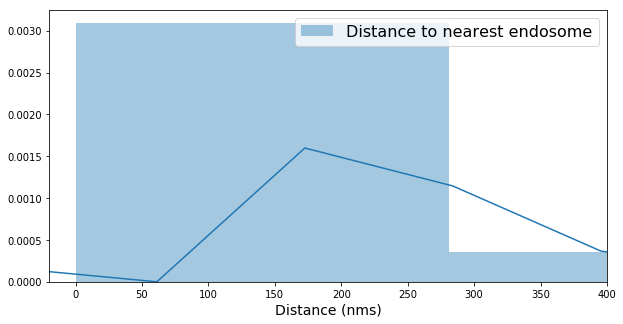

In [645]:
fig=plt.figure(figsize=(10,5))
g=sns.distplot(df_ecm["distance to nearest endosome centroid [nms]"],label="Distance to nearest endosome")
#g=sns.kdeplot(df_endosome["distance to nearest ecm centroid [nms]"],shade=True)
#g=sns.distplot(df_ecm["distance to nearest synapse centroid [nms]"],label="Distance to nearest synapse")
g.set_xticks(np.linspace(0,500,11))
g.set_xlim([-20,400])
plt.legend(fontsize=16)
g.set_xlabel('Distance (nms)',fontsize=14)

In [218]:
df_ecm["exp condition"].unique()

array(['20190612_tnr550_blkplus12_tgn38acy2_analyse',
       '20190523_tnr550_intfitc_blockedplus12_stripped',
       '20190605_tnr647blockplus12_int1fitc_contactincy3',
       '20190515_TNR550_Int1beta_stripped_plus12hr',
       '20190515_TNR550_Int1beta_stripped_plus12hr_cs34',
       '20190612_tnr550_blkplus12_rab11acy2',
       '20190612_tnr550_blkplus2_cav1cy2',
       '20190612_tnr647_blkplus12_tgn38acy2',
       '20190605_tnr647blockplus12_tgn38cy2_doesntlookblocked',
       '20190605_tnr647blockplus12_rab11acy2',
       '20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse',
       '20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging',
       '20190612_tnr647_blkplus12_intfitc_ctccy3_stripped',
       '20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse',
       '20190505_tnr550_blkplus0_postliveexp_cav1cy2_goodparams',
       '20190522_tnr550_blkplus2_cav1cy2_goodparams',
       '20190522_tnr550_blkplus20min_cav1cy2_goodp

In [651]:
df_ecm['Protein']='None'
df_ecm.loc[(df_ecm['exp condition'].str.contains('nt'))&(df_ecm['exp condition'].str.contains('12')), 'Protein'] = 'Int1b, all TNR Blk+12, stripped'
df_ecm.loc[(df_ecm['exp condition'].str.contains('nt'))&(df_ecm['exp condition'].str.contains('surface')), 'Protein'] = 'Int1b Blk/TNR Blk, +0, surface'
df_ecm.loc[df_ecm['exp condition'].str.contains('tgn'), 'Protein'] = 'TGN38/ TNR Blk, +12'
df_ecm.loc[df_ecm['exp condition'].str.contains('rab'), 'Protein'] = 'Rab11a/ TNR Blk, +12'
df_ecm.loc[df_ecm['exp condition'].str.contains('cav'), 'Protein'] = 'Cav1/ TNR Blk'

In [646]:
df_ecm['Protein']='None'
df_ecm['Treatment']='None'
df_ecm.loc[df_ecm['exp condition'].str.contains('cav'), 'Protein'] = 'Caveolin 1'
df_ecm.loc[df_ecm['exp condition'].str.contains('Rab5'), 'Protein'] = 'Rab5'
df_ecm.loc[df_ecm['exp condition'].str.contains('Rab7'), 'Protein'] = 'Rab7'
df_ecm.loc[df_ecm['exp condition'].str.contains('Ctrl'), 'Treatment'] = 'Unblocked Control'
df_ecm.loc[df_ecm['exp condition'].str.contains('Blk'), 'Treatment'] = 'Blocked'
df_endosome['Protein']='None'
df_endosome['Treatment']='None'
df_endosome.loc[df_endosome['exp condition'].str.contains('cav'), 'Protein'] = 'Caveolin 1'
df_endosome.loc[df_endosome['exp condition'].str.contains('Rab5'), 'Protein'] = 'Rab5'
df_endosome.loc[df_endosome['exp condition'].str.contains('Rab7'), 'Protein'] = 'Rab7'
df_endosome.loc[df_endosome['exp condition'].str.contains('Ctrl'), 'Treatment'] = 'Unblocked Control'
df_endosome.loc[df_endosome['exp condition'].str.contains('Blk'), 'Treatment'] = 'Blocked'


In [425]:
df_ecm['Distance to endosome']='>50nm'
df_ecm.loc[df_ecm["distance to nearest endosome centroid [nms]"]<50,'Distance to endosome']='<50nm'

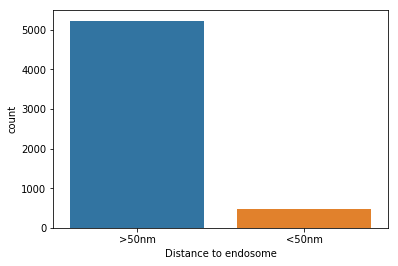

In [426]:
sns.countplot(x="Distance to endosome", data=df_ecm)

In [427]:
df_ecm["distance to nearest endosome centroid [nms]"].min()

0.0

KeyError: 'Distance to endosome'

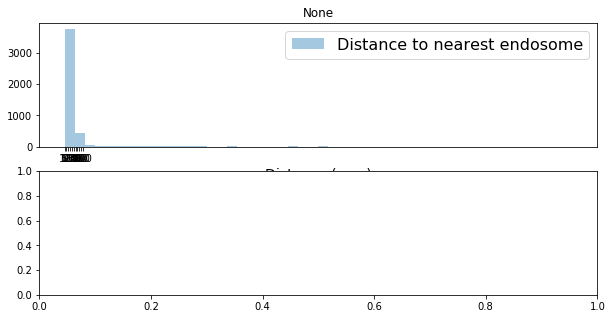

In [647]:
for protein in df_ecm["Protein"].unique():
    #df2plot=df_ecm[(df_ecm["Treatment"]=="Unblocked Control")&(df_ecm["Protein"]==protein)]
    df2plot=df_ecm[(df_ecm["Protein"]==protein)]
    fig=plt.figure(figsize=(10,5))
    fig.add_subplot(211)
    g=sns.distplot(df2plot["distance to nearest endosome centroid [nms]"],label="Distance to nearest endosome",kde=False)
    g.set_xticks(np.linspace(0,500,11))
    #g.set_xlim([-20,700])
    plt.legend(fontsize=16)
    g.set_xlabel('Distance (nms)',fontsize=14)
    plt.title(protein)
    
    fig.add_subplot(212)
    dfcount=df2plot.groupby("Distance to endosome").count()
    smallerthan=dfcount["filename"].unique()[0]
    biggerthan=dfcount["filename"].unique()[1]
    propsmaller=smallerthan/(smallerthan+biggerthan)
    propbigger=biggerthan/(smallerthan+biggerthan)
    dfprops={'Distance':['<50nm','>50nm'],'Percentage':[propsmaller,propbigger]}
    dfprops=pd.DataFrame(dfprops)
    sns.barplot(x="Distance",y="Percentage",data=dfprops)
    plt.text(x=-0.1,y=0.2,s=np.round(propsmaller,3))
    plt.text(x=0.8,y=0.2,s=np.round(propbigger,3))
    
    
    fig.tight_layout()

## Calculate for TNR rotated image (how much randomly colocalizes)

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


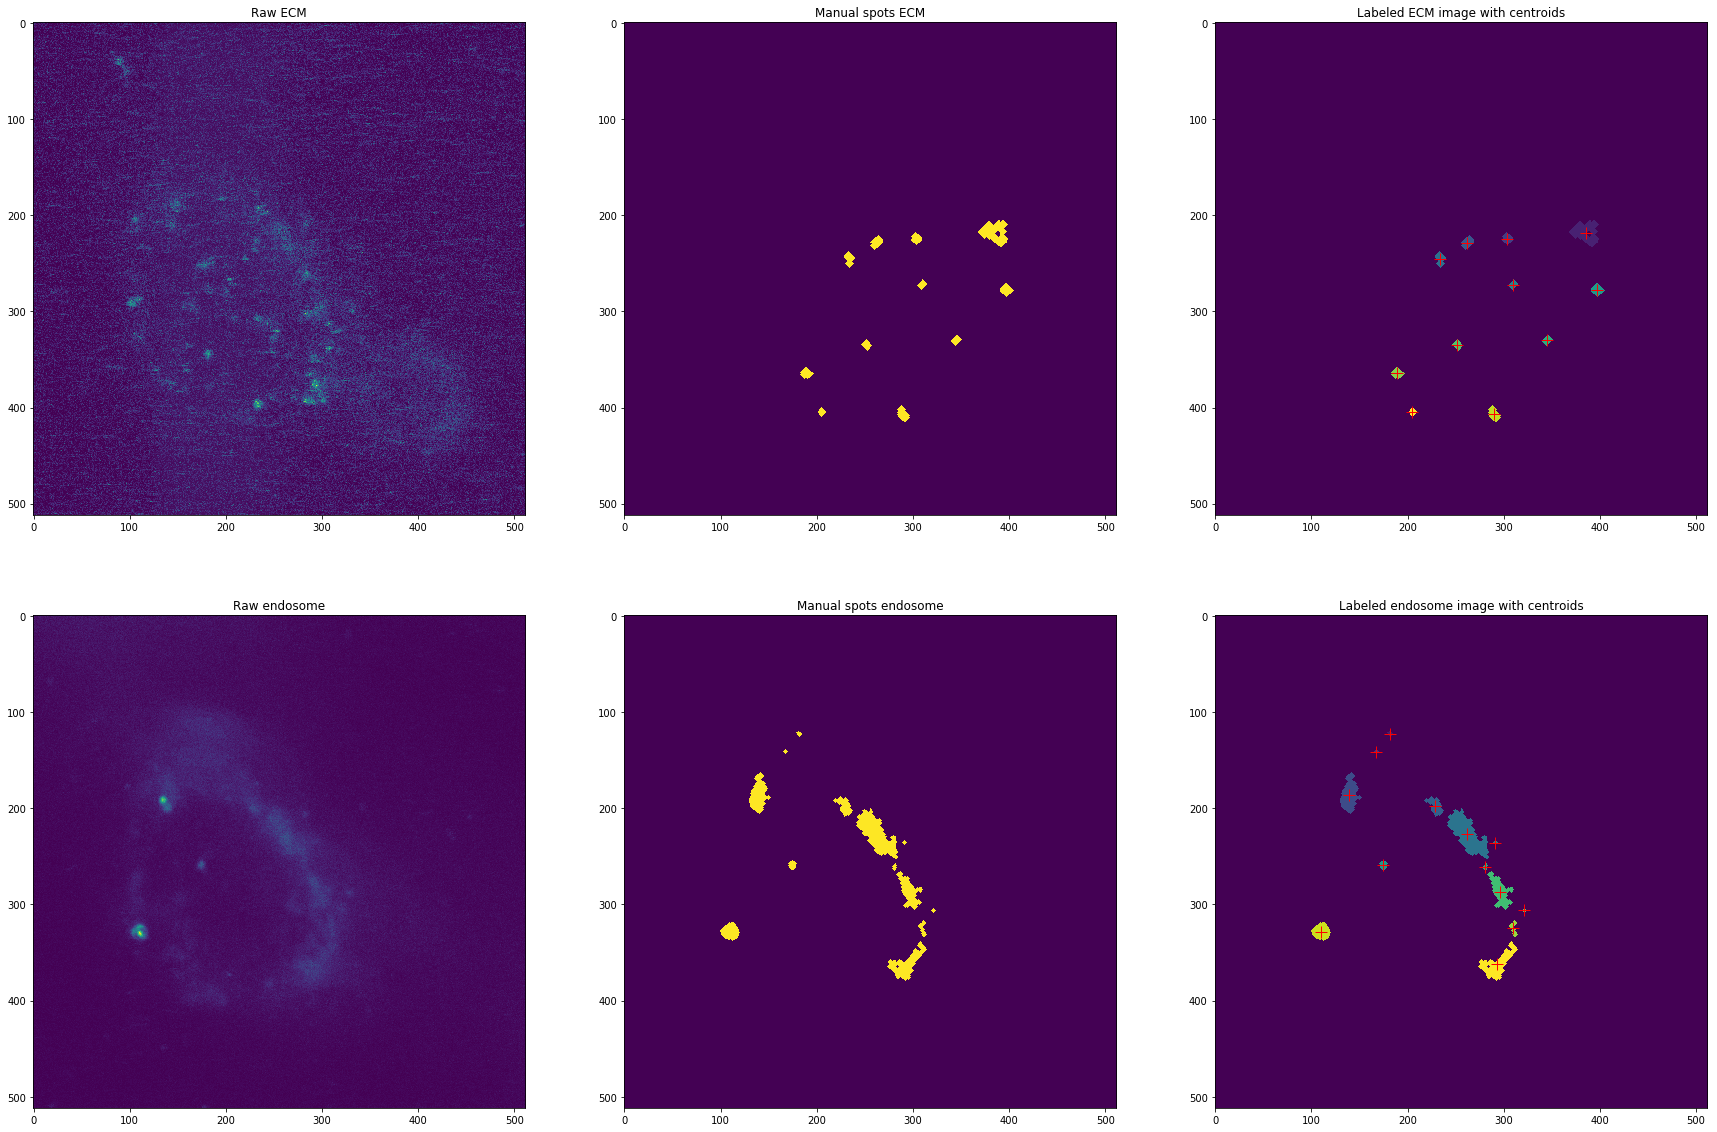

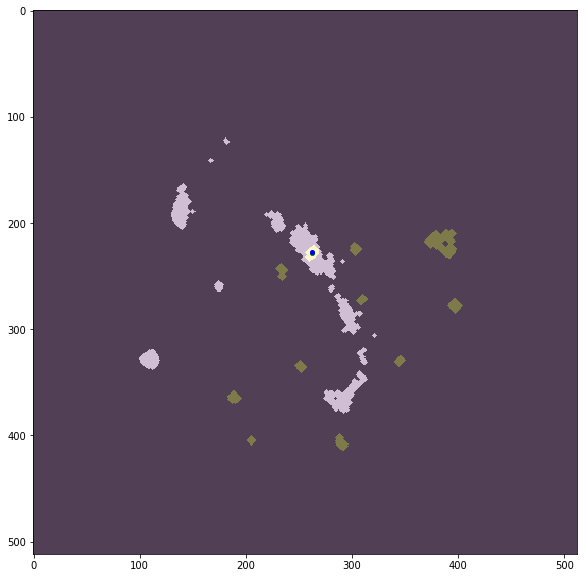

In [661]:
## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest endosome centroid":[],
                 "distance to nearest endosome centroid [nms]":[]
                  }
endosome_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                       "distance to nearest ecm centroid [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    #ecm_channel_no=results["ecmchannelno"][image]
    #endosome_channel_no=results["endosomechannelno"][image]

    #ecm_image_name=results["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    #endosome_image_name=results["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

    print("Image name:",results["filename"][image].split('/')[-1])
    print("Experimental condition:",results["exp condition"][image])
    #ecm_image=pims.open(ecm_image_name)[0]
    #endosome_image=pims.open(endosome_image_name)[0]
    
    #read spots masks and label
    ecm_mask=results["Manual ECM spots mask"][image]
    endosome_mask=results["Manual endosome spots mask"][image]
    #if np.isnan(endosome_mask)==True:
    #    endosome_mask= endosome_mask
    #else:
    if np.ndim(ecm_mask)>0:
        ecm_mask=np.flip(ecm_mask)
            
    #np.random.shuffle(endosome_mask)
    labeled_ecm=label(ecm_mask)
    labeled_endosome=label(endosome_mask)
    
    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_endosome=regionprops(labeled_endosome)

    for i in range(0,len(regionprops_ecm)):
        ecm_spots_results["filename"].append(results["filename"][image])
        ecm_spots_results["exp condition"].append(results["exp condition"][image])
        ecm_spots_results["spotno"].append(i)
        ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'])
        ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_endosome)):
        endosome_spots_results["filename"].append(results["filename"][image])
        endosome_spots_results["exp condition"].append(results["exp condition"][image])
        endosome_spots_results["spotno"].append(i)
        endosome_spots_results["centroid"].append(regionprops_endosome[i]['centroid'])
        endosome_spots_results["size"].append(regionprops_endosome[i]['area'])
    

Calculating image no 1 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series8_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 2 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series9_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 3 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series0_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 4 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series1_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 5 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series2_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 6 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series3_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 7 out of168
Image name: 2

Calculating image no 53 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series4_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2
Calculating image no 54 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series3_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2
Calculating image no 55 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series2_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2
Calculating image no 56 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series1_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2
Calculating image no 57 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series0_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2
Calculating image no 58 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series9_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2
Calculating image no 59 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series8_z
Exper

Calculating image no 108 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series4_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging
Calculating image no 109 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series3_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging
Calculating image no 110 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series2_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging
Calculating image no 111 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series1_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging
Calculating image no 112 out of168
Image name: 20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging_Series13_z
Experimental condition: 20190526_tnr550blocked_int1fitcblocked_plus0h

Calculating image no 155 out of168
Image name: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams_Series3_z
Experimental condition: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams
Calculating image no 156 out of168
Image name: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams_Series2_z
Experimental condition: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams
Calculating image no 157 out of168
Image name: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams_Series1_z
Experimental condition: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams
Calculating image no 158 out of168
Image name: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams_Series0_z
Experimental condition: 20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams
Calculating image no 159 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series9_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2
Calculating image no 160 out of168
Image name: 20190612_tnr647_blkplus12_ra

In [662]:
## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest endosome centroid":[],
                 "distance to nearest endosome centroid [nms]":[]
                  }
endosome_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                       "distance to nearest ecm centroid [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    #ecm_channel_no=results["ecmchannelno"][image]
    #endosome_channel_no=results["endosomechannelno"][image]

    #ecm_image_name=results["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    #endosome_image_name=results["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

    print("Image name:",results["filename"][image].split('/')[-1])
    print("Experimental condition:",results["exp condition"][image])
    #ecm_image=pims.open(ecm_image_name)[0]
    #endosome_image=pims.open(endosome_image_name)[0]
    
    #read spots masks and label
    ecm_mask=results["Manual ECM spots mask"][image]
    endosome_mask=results["Manual endosome spots mask"][image]
    ecm_mask=np.flip(ecm_mask)
    labeled_ecm=label(ecm_mask)
    labeled_endosome=label(endosome_mask)
    
    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_endosome=regionprops(labeled_endosome)

    for i in range(0,len(regionprops_ecm)):
        ecm_spots_results["filename"].append(results["filename"][image])
        ecm_spots_results["exp condition"].append(results["exp condition"][image])
        ecm_spots_results["spotno"].append(i)
        ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'])
        ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_endosome)):
        endosome_spots_results["filename"].append(results["filename"][image])
        endosome_spots_results["exp condition"].append(results["exp condition"][image])
        endosome_spots_results["spotno"].append(i)
        endosome_spots_results["centroid"].append(regionprops_endosome[i]['coords'][0])
        endosome_spots_results["size"].append(regionprops_endosome[i]['area'])
    

Calculating image no 1 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series8_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 2 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series9_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 3 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series0_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 4 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series1_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 5 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series2_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 6 out of168
Image name: 20190612_tnr550_blkplus12_tgn38acy2_Series3_z
Experimental condition: 20190612_tnr550_blkplus12_tgn38acy2_analyse
Calculating image no 7 out of168
Image name: 2

Calculating image no 54 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series3_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2
Calculating image no 55 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series2_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2
Calculating image no 56 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series1_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2
Calculating image no 57 out of168
Image name: 20190612_tnr550_blkplus12_rab11acy2_Series0_z
Experimental condition: 20190612_tnr550_blkplus12_rab11acy2
Calculating image no 58 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series9_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2
Calculating image no 59 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series8_z
Experimental condition: 20190612_tnr550_blkplus2_cav1cy2
Calculating image no 60 out of168
Image name: 20190612_tnr550_blkplus2_cav1cy2_Series7_z
Experimenta

Calculating image no 121 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series3_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped
Calculating image no 122 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series2_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped
Calculating image no 123 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series1_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped
Calculating image no 124 out of168
Image name: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped_Series0_z
Experimental condition: 20190612_tnr647_blkplus12_intfitc_ctccy3_stripped
Calculating image no 125 out of168
Image name: 20190611_tnr550_blkplus0_int1fitcblk_ctc1amca_vglut635p_onlysurface_Series7_z
Experimental condition: 20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse
Calculating image no 126 out of168
Image 

Calculating image no 167 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series1_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2
Calculating image no 168 out of168
Image name: 20190612_tnr647_blkplus12_rab11acy2_Series0_z
Experimental condition: 20190612_tnr647_blkplus12_rab11acy2


In [436]:
results["Manual endosome spots mask"][image]=results["Manual endosome spots mask"][image-1]

In [438]:
for i in range(0,len(ecm_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(ecm_spots_results["filename"])))
    ecm_spots_results["distance to nearest endosome centroid"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     endosome_spots_results["centroid"],'euclidean').min())
                                   
    ecm_spots_results["distance to nearest endosome centroid [nms]"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     endosome_spots_results["centroid"],'euclidean').min()*40.6)
    
for i in range(0,len(endosome_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(endosome_spots_results["filename"])))
    endosome_spots_results["distance to nearest ecm centroid"].append(
        scipy.spatial.distance.cdist([endosome_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min())
    
                                     
    endosome_spots_results["distance to nearest ecm centroid [nms]"].append(
        scipy.spatial.distance.cdist([endosome_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min()*40.6)

1 out of 6354
2 out of 6354
3 out of 6354
4 out of 6354
5 out of 6354
6 out of 6354
7 out of 6354
8 out of 6354
9 out of 6354
10 out of 6354
11 out of 6354
12 out of 6354
13 out of 6354
14 out of 6354
15 out of 6354
16 out of 6354
17 out of 6354
18 out of 6354
19 out of 6354
20 out of 6354
21 out of 6354
22 out of 6354
23 out of 6354
24 out of 6354
25 out of 6354
26 out of 6354
27 out of 6354
28 out of 6354
29 out of 6354
30 out of 6354
31 out of 6354
32 out of 6354
33 out of 6354
34 out of 6354
35 out of 6354
36 out of 6354
37 out of 6354
38 out of 6354
39 out of 6354
40 out of 6354
41 out of 6354
42 out of 6354
43 out of 6354
44 out of 6354
45 out of 6354
46 out of 6354
47 out of 6354
48 out of 6354
49 out of 6354
50 out of 6354
51 out of 6354
52 out of 6354
53 out of 6354
54 out of 6354
55 out of 6354
56 out of 6354
57 out of 6354
58 out of 6354
59 out of 6354
60 out of 6354
61 out of 6354
62 out of 6354
63 out of 6354
64 out of 6354
65 out of 6354
66 out of 6354
67 out of 6354
68 o

525 out of 6354
526 out of 6354
527 out of 6354
528 out of 6354
529 out of 6354
530 out of 6354
531 out of 6354
532 out of 6354
533 out of 6354
534 out of 6354
535 out of 6354
536 out of 6354
537 out of 6354
538 out of 6354
539 out of 6354
540 out of 6354
541 out of 6354
542 out of 6354
543 out of 6354
544 out of 6354
545 out of 6354
546 out of 6354
547 out of 6354
548 out of 6354
549 out of 6354
550 out of 6354
551 out of 6354
552 out of 6354
553 out of 6354
554 out of 6354
555 out of 6354
556 out of 6354
557 out of 6354
558 out of 6354
559 out of 6354
560 out of 6354
561 out of 6354
562 out of 6354
563 out of 6354
564 out of 6354
565 out of 6354
566 out of 6354
567 out of 6354
568 out of 6354
569 out of 6354
570 out of 6354
571 out of 6354
572 out of 6354
573 out of 6354
574 out of 6354
575 out of 6354
576 out of 6354
577 out of 6354
578 out of 6354
579 out of 6354
580 out of 6354
581 out of 6354
582 out of 6354
583 out of 6354
584 out of 6354
585 out of 6354
586 out of 6354
587 out 

1044 out of 6354
1045 out of 6354
1046 out of 6354
1047 out of 6354
1048 out of 6354
1049 out of 6354
1050 out of 6354
1051 out of 6354
1052 out of 6354
1053 out of 6354
1054 out of 6354
1055 out of 6354
1056 out of 6354
1057 out of 6354
1058 out of 6354
1059 out of 6354
1060 out of 6354
1061 out of 6354
1062 out of 6354
1063 out of 6354
1064 out of 6354
1065 out of 6354
1066 out of 6354
1067 out of 6354
1068 out of 6354
1069 out of 6354
1070 out of 6354
1071 out of 6354
1072 out of 6354
1073 out of 6354
1074 out of 6354
1075 out of 6354
1076 out of 6354
1077 out of 6354
1078 out of 6354
1079 out of 6354
1080 out of 6354
1081 out of 6354
1082 out of 6354
1083 out of 6354
1084 out of 6354
1085 out of 6354
1086 out of 6354
1087 out of 6354
1088 out of 6354
1089 out of 6354
1090 out of 6354
1091 out of 6354
1092 out of 6354
1093 out of 6354
1094 out of 6354
1095 out of 6354
1096 out of 6354
1097 out of 6354
1098 out of 6354
1099 out of 6354
1100 out of 6354
1101 out of 6354
1102 out of 63

1529 out of 6354
1530 out of 6354
1531 out of 6354
1532 out of 6354
1533 out of 6354
1534 out of 6354
1535 out of 6354
1536 out of 6354
1537 out of 6354
1538 out of 6354
1539 out of 6354
1540 out of 6354
1541 out of 6354
1542 out of 6354
1543 out of 6354
1544 out of 6354
1545 out of 6354
1546 out of 6354
1547 out of 6354
1548 out of 6354
1549 out of 6354
1550 out of 6354
1551 out of 6354
1552 out of 6354
1553 out of 6354
1554 out of 6354
1555 out of 6354
1556 out of 6354
1557 out of 6354
1558 out of 6354
1559 out of 6354
1560 out of 6354
1561 out of 6354
1562 out of 6354
1563 out of 6354
1564 out of 6354
1565 out of 6354
1566 out of 6354
1567 out of 6354
1568 out of 6354
1569 out of 6354
1570 out of 6354
1571 out of 6354
1572 out of 6354
1573 out of 6354
1574 out of 6354
1575 out of 6354
1576 out of 6354
1577 out of 6354
1578 out of 6354
1579 out of 6354
1580 out of 6354
1581 out of 6354
1582 out of 6354
1583 out of 6354
1584 out of 6354
1585 out of 6354
1586 out of 6354
1587 out of 63

2017 out of 6354
2018 out of 6354
2019 out of 6354
2020 out of 6354
2021 out of 6354
2022 out of 6354
2023 out of 6354
2024 out of 6354
2025 out of 6354
2026 out of 6354
2027 out of 6354
2028 out of 6354
2029 out of 6354
2030 out of 6354
2031 out of 6354
2032 out of 6354
2033 out of 6354
2034 out of 6354
2035 out of 6354
2036 out of 6354
2037 out of 6354
2038 out of 6354
2039 out of 6354
2040 out of 6354
2041 out of 6354
2042 out of 6354
2043 out of 6354
2044 out of 6354
2045 out of 6354
2046 out of 6354
2047 out of 6354
2048 out of 6354
2049 out of 6354
2050 out of 6354
2051 out of 6354
2052 out of 6354
2053 out of 6354
2054 out of 6354
2055 out of 6354
2056 out of 6354
2057 out of 6354
2058 out of 6354
2059 out of 6354
2060 out of 6354
2061 out of 6354
2062 out of 6354
2063 out of 6354
2064 out of 6354
2065 out of 6354
2066 out of 6354
2067 out of 6354
2068 out of 6354
2069 out of 6354
2070 out of 6354
2071 out of 6354
2072 out of 6354
2073 out of 6354
2074 out of 6354
2075 out of 63

2500 out of 6354
2501 out of 6354
2502 out of 6354
2503 out of 6354
2504 out of 6354
2505 out of 6354
2506 out of 6354
2507 out of 6354
2508 out of 6354
2509 out of 6354
2510 out of 6354
2511 out of 6354
2512 out of 6354
2513 out of 6354
2514 out of 6354
2515 out of 6354
2516 out of 6354
2517 out of 6354
2518 out of 6354
2519 out of 6354
2520 out of 6354
2521 out of 6354
2522 out of 6354
2523 out of 6354
2524 out of 6354
2525 out of 6354
2526 out of 6354
2527 out of 6354
2528 out of 6354
2529 out of 6354
2530 out of 6354
2531 out of 6354
2532 out of 6354
2533 out of 6354
2534 out of 6354
2535 out of 6354
2536 out of 6354
2537 out of 6354
2538 out of 6354
2539 out of 6354
2540 out of 6354
2541 out of 6354
2542 out of 6354
2543 out of 6354
2544 out of 6354
2545 out of 6354
2546 out of 6354
2547 out of 6354
2548 out of 6354
2549 out of 6354
2550 out of 6354
2551 out of 6354
2552 out of 6354
2553 out of 6354
2554 out of 6354
2555 out of 6354
2556 out of 6354
2557 out of 6354
2558 out of 63

2982 out of 6354
2983 out of 6354
2984 out of 6354
2985 out of 6354
2986 out of 6354
2987 out of 6354
2988 out of 6354
2989 out of 6354
2990 out of 6354
2991 out of 6354
2992 out of 6354
2993 out of 6354
2994 out of 6354
2995 out of 6354
2996 out of 6354
2997 out of 6354
2998 out of 6354
2999 out of 6354
3000 out of 6354
3001 out of 6354
3002 out of 6354
3003 out of 6354
3004 out of 6354
3005 out of 6354
3006 out of 6354
3007 out of 6354
3008 out of 6354
3009 out of 6354
3010 out of 6354
3011 out of 6354
3012 out of 6354
3013 out of 6354
3014 out of 6354
3015 out of 6354
3016 out of 6354
3017 out of 6354
3018 out of 6354
3019 out of 6354
3020 out of 6354
3021 out of 6354
3022 out of 6354
3023 out of 6354
3024 out of 6354
3025 out of 6354
3026 out of 6354
3027 out of 6354
3028 out of 6354
3029 out of 6354
3030 out of 6354
3031 out of 6354
3032 out of 6354
3033 out of 6354
3034 out of 6354
3035 out of 6354
3036 out of 6354
3037 out of 6354
3038 out of 6354
3039 out of 6354
3040 out of 63

3471 out of 6354
3472 out of 6354
3473 out of 6354
3474 out of 6354
3475 out of 6354
3476 out of 6354
3477 out of 6354
3478 out of 6354
3479 out of 6354
3480 out of 6354
3481 out of 6354
3482 out of 6354
3483 out of 6354
3484 out of 6354
3485 out of 6354
3486 out of 6354
3487 out of 6354
3488 out of 6354
3489 out of 6354
3490 out of 6354
3491 out of 6354
3492 out of 6354
3493 out of 6354
3494 out of 6354
3495 out of 6354
3496 out of 6354
3497 out of 6354
3498 out of 6354
3499 out of 6354
3500 out of 6354
3501 out of 6354
3502 out of 6354
3503 out of 6354
3504 out of 6354
3505 out of 6354
3506 out of 6354
3507 out of 6354
3508 out of 6354
3509 out of 6354
3510 out of 6354
3511 out of 6354
3512 out of 6354
3513 out of 6354
3514 out of 6354
3515 out of 6354
3516 out of 6354
3517 out of 6354
3518 out of 6354
3519 out of 6354
3520 out of 6354
3521 out of 6354
3522 out of 6354
3523 out of 6354
3524 out of 6354
3525 out of 6354
3526 out of 6354
3527 out of 6354
3528 out of 6354
3529 out of 63

3957 out of 6354
3958 out of 6354
3959 out of 6354
3960 out of 6354
3961 out of 6354
3962 out of 6354
3963 out of 6354
3964 out of 6354
3965 out of 6354
3966 out of 6354
3967 out of 6354
3968 out of 6354
3969 out of 6354
3970 out of 6354
3971 out of 6354
3972 out of 6354
3973 out of 6354
3974 out of 6354
3975 out of 6354
3976 out of 6354
3977 out of 6354
3978 out of 6354
3979 out of 6354
3980 out of 6354
3981 out of 6354
3982 out of 6354
3983 out of 6354
3984 out of 6354
3985 out of 6354
3986 out of 6354
3987 out of 6354
3988 out of 6354
3989 out of 6354
3990 out of 6354
3991 out of 6354
3992 out of 6354
3993 out of 6354
3994 out of 6354
3995 out of 6354
3996 out of 6354
3997 out of 6354
3998 out of 6354
3999 out of 6354
4000 out of 6354
4001 out of 6354
4002 out of 6354
4003 out of 6354
4004 out of 6354
4005 out of 6354
4006 out of 6354
4007 out of 6354
4008 out of 6354
4009 out of 6354
4010 out of 6354
4011 out of 6354
4012 out of 6354
4013 out of 6354
4014 out of 6354
4015 out of 63

4449 out of 6354
4450 out of 6354
4451 out of 6354
4452 out of 6354
4453 out of 6354
4454 out of 6354
4455 out of 6354
4456 out of 6354
4457 out of 6354
4458 out of 6354
4459 out of 6354
4460 out of 6354
4461 out of 6354
4462 out of 6354
4463 out of 6354
4464 out of 6354
4465 out of 6354
4466 out of 6354
4467 out of 6354
4468 out of 6354
4469 out of 6354
4470 out of 6354
4471 out of 6354
4472 out of 6354
4473 out of 6354
4474 out of 6354
4475 out of 6354
4476 out of 6354
4477 out of 6354
4478 out of 6354
4479 out of 6354
4480 out of 6354
4481 out of 6354
4482 out of 6354
4483 out of 6354
4484 out of 6354
4485 out of 6354
4486 out of 6354
4487 out of 6354
4488 out of 6354
4489 out of 6354
4490 out of 6354
4491 out of 6354
4492 out of 6354
4493 out of 6354
4494 out of 6354
4495 out of 6354
4496 out of 6354
4497 out of 6354
4498 out of 6354
4499 out of 6354
4500 out of 6354
4501 out of 6354
4502 out of 6354
4503 out of 6354
4504 out of 6354
4505 out of 6354
4506 out of 6354
4507 out of 63

4931 out of 6354
4932 out of 6354
4933 out of 6354
4934 out of 6354
4935 out of 6354
4936 out of 6354
4937 out of 6354
4938 out of 6354
4939 out of 6354
4940 out of 6354
4941 out of 6354
4942 out of 6354
4943 out of 6354
4944 out of 6354
4945 out of 6354
4946 out of 6354
4947 out of 6354
4948 out of 6354
4949 out of 6354
4950 out of 6354
4951 out of 6354
4952 out of 6354
4953 out of 6354
4954 out of 6354
4955 out of 6354
4956 out of 6354
4957 out of 6354
4958 out of 6354
4959 out of 6354
4960 out of 6354
4961 out of 6354
4962 out of 6354
4963 out of 6354
4964 out of 6354
4965 out of 6354
4966 out of 6354
4967 out of 6354
4968 out of 6354
4969 out of 6354
4970 out of 6354
4971 out of 6354
4972 out of 6354
4973 out of 6354
4974 out of 6354
4975 out of 6354
4976 out of 6354
4977 out of 6354
4978 out of 6354
4979 out of 6354
4980 out of 6354
4981 out of 6354
4982 out of 6354
4983 out of 6354
4984 out of 6354
4985 out of 6354
4986 out of 6354
4987 out of 6354
4988 out of 6354
4989 out of 63

5413 out of 6354
5414 out of 6354
5415 out of 6354
5416 out of 6354
5417 out of 6354
5418 out of 6354
5419 out of 6354
5420 out of 6354
5421 out of 6354
5422 out of 6354
5423 out of 6354
5424 out of 6354
5425 out of 6354
5426 out of 6354
5427 out of 6354
5428 out of 6354
5429 out of 6354
5430 out of 6354
5431 out of 6354
5432 out of 6354
5433 out of 6354
5434 out of 6354
5435 out of 6354
5436 out of 6354
5437 out of 6354
5438 out of 6354
5439 out of 6354
5440 out of 6354
5441 out of 6354
5442 out of 6354
5443 out of 6354
5444 out of 6354
5445 out of 6354
5446 out of 6354
5447 out of 6354
5448 out of 6354
5449 out of 6354
5450 out of 6354
5451 out of 6354
5452 out of 6354
5453 out of 6354
5454 out of 6354
5455 out of 6354
5456 out of 6354
5457 out of 6354
5458 out of 6354
5459 out of 6354
5460 out of 6354
5461 out of 6354
5462 out of 6354
5463 out of 6354
5464 out of 6354
5465 out of 6354
5466 out of 6354
5467 out of 6354
5468 out of 6354
5469 out of 6354
5470 out of 6354
5471 out of 63

5898 out of 6354
5899 out of 6354
5900 out of 6354
5901 out of 6354
5902 out of 6354
5903 out of 6354
5904 out of 6354
5905 out of 6354
5906 out of 6354
5907 out of 6354
5908 out of 6354
5909 out of 6354
5910 out of 6354
5911 out of 6354
5912 out of 6354
5913 out of 6354
5914 out of 6354
5915 out of 6354
5916 out of 6354
5917 out of 6354
5918 out of 6354
5919 out of 6354
5920 out of 6354
5921 out of 6354
5922 out of 6354
5923 out of 6354
5924 out of 6354
5925 out of 6354
5926 out of 6354
5927 out of 6354
5928 out of 6354
5929 out of 6354
5930 out of 6354
5931 out of 6354
5932 out of 6354
5933 out of 6354
5934 out of 6354
5935 out of 6354
5936 out of 6354
5937 out of 6354
5938 out of 6354
5939 out of 6354
5940 out of 6354
5941 out of 6354
5942 out of 6354
5943 out of 6354
5944 out of 6354
5945 out of 6354
5946 out of 6354
5947 out of 6354
5948 out of 6354
5949 out of 6354
5950 out of 6354
5951 out of 6354
5952 out of 6354
5953 out of 6354
5954 out of 6354
5955 out of 6354
5956 out of 63

32 out of 4420
33 out of 4420
34 out of 4420
35 out of 4420
36 out of 4420
37 out of 4420
38 out of 4420
39 out of 4420
40 out of 4420
41 out of 4420
42 out of 4420
43 out of 4420
44 out of 4420
45 out of 4420
46 out of 4420
47 out of 4420
48 out of 4420
49 out of 4420
50 out of 4420
51 out of 4420
52 out of 4420
53 out of 4420
54 out of 4420
55 out of 4420
56 out of 4420
57 out of 4420
58 out of 4420
59 out of 4420
60 out of 4420
61 out of 4420
62 out of 4420
63 out of 4420
64 out of 4420
65 out of 4420
66 out of 4420
67 out of 4420
68 out of 4420
69 out of 4420
70 out of 4420
71 out of 4420
72 out of 4420
73 out of 4420
74 out of 4420
75 out of 4420
76 out of 4420
77 out of 4420
78 out of 4420
79 out of 4420
80 out of 4420
81 out of 4420
82 out of 4420
83 out of 4420
84 out of 4420
85 out of 4420
86 out of 4420
87 out of 4420
88 out of 4420
89 out of 4420
90 out of 4420
91 out of 4420
92 out of 4420
93 out of 4420
94 out of 4420
95 out of 4420
96 out of 4420
97 out of 4420
98 out of 

552 out of 4420
553 out of 4420
554 out of 4420
555 out of 4420
556 out of 4420
557 out of 4420
558 out of 4420
559 out of 4420
560 out of 4420
561 out of 4420
562 out of 4420
563 out of 4420
564 out of 4420
565 out of 4420
566 out of 4420
567 out of 4420
568 out of 4420
569 out of 4420
570 out of 4420
571 out of 4420
572 out of 4420
573 out of 4420
574 out of 4420
575 out of 4420
576 out of 4420
577 out of 4420
578 out of 4420
579 out of 4420
580 out of 4420
581 out of 4420
582 out of 4420
583 out of 4420
584 out of 4420
585 out of 4420
586 out of 4420
587 out of 4420
588 out of 4420
589 out of 4420
590 out of 4420
591 out of 4420
592 out of 4420
593 out of 4420
594 out of 4420
595 out of 4420
596 out of 4420
597 out of 4420
598 out of 4420
599 out of 4420
600 out of 4420
601 out of 4420
602 out of 4420
603 out of 4420
604 out of 4420
605 out of 4420
606 out of 4420
607 out of 4420
608 out of 4420
609 out of 4420
610 out of 4420
611 out of 4420
612 out of 4420
613 out of 4420
614 out 

1065 out of 4420
1066 out of 4420
1067 out of 4420
1068 out of 4420
1069 out of 4420
1070 out of 4420
1071 out of 4420
1072 out of 4420
1073 out of 4420
1074 out of 4420
1075 out of 4420
1076 out of 4420
1077 out of 4420
1078 out of 4420
1079 out of 4420
1080 out of 4420
1081 out of 4420
1082 out of 4420
1083 out of 4420
1084 out of 4420
1085 out of 4420
1086 out of 4420
1087 out of 4420
1088 out of 4420
1089 out of 4420
1090 out of 4420
1091 out of 4420
1092 out of 4420
1093 out of 4420
1094 out of 4420
1095 out of 4420
1096 out of 4420
1097 out of 4420
1098 out of 4420
1099 out of 4420
1100 out of 4420
1101 out of 4420
1102 out of 4420
1103 out of 4420
1104 out of 4420
1105 out of 4420
1106 out of 4420
1107 out of 4420
1108 out of 4420
1109 out of 4420
1110 out of 4420
1111 out of 4420
1112 out of 4420
1113 out of 4420
1114 out of 4420
1115 out of 4420
1116 out of 4420
1117 out of 4420
1118 out of 4420
1119 out of 4420
1120 out of 4420
1121 out of 4420
1122 out of 4420
1123 out of 44

1547 out of 4420
1548 out of 4420
1549 out of 4420
1550 out of 4420
1551 out of 4420
1552 out of 4420
1553 out of 4420
1554 out of 4420
1555 out of 4420
1556 out of 4420
1557 out of 4420
1558 out of 4420
1559 out of 4420
1560 out of 4420
1561 out of 4420
1562 out of 4420
1563 out of 4420
1564 out of 4420
1565 out of 4420
1566 out of 4420
1567 out of 4420
1568 out of 4420
1569 out of 4420
1570 out of 4420
1571 out of 4420
1572 out of 4420
1573 out of 4420
1574 out of 4420
1575 out of 4420
1576 out of 4420
1577 out of 4420
1578 out of 4420
1579 out of 4420
1580 out of 4420
1581 out of 4420
1582 out of 4420
1583 out of 4420
1584 out of 4420
1585 out of 4420
1586 out of 4420
1587 out of 4420
1588 out of 4420
1589 out of 4420
1590 out of 4420
1591 out of 4420
1592 out of 4420
1593 out of 4420
1594 out of 4420
1595 out of 4420
1596 out of 4420
1597 out of 4420
1598 out of 4420
1599 out of 4420
1600 out of 4420
1601 out of 4420
1602 out of 4420
1603 out of 4420
1604 out of 4420
1605 out of 44

2033 out of 4420
2034 out of 4420
2035 out of 4420
2036 out of 4420
2037 out of 4420
2038 out of 4420
2039 out of 4420
2040 out of 4420
2041 out of 4420
2042 out of 4420
2043 out of 4420
2044 out of 4420
2045 out of 4420
2046 out of 4420
2047 out of 4420
2048 out of 4420
2049 out of 4420
2050 out of 4420
2051 out of 4420
2052 out of 4420
2053 out of 4420
2054 out of 4420
2055 out of 4420
2056 out of 4420
2057 out of 4420
2058 out of 4420
2059 out of 4420
2060 out of 4420
2061 out of 4420
2062 out of 4420
2063 out of 4420
2064 out of 4420
2065 out of 4420
2066 out of 4420
2067 out of 4420
2068 out of 4420
2069 out of 4420
2070 out of 4420
2071 out of 4420
2072 out of 4420
2073 out of 4420
2074 out of 4420
2075 out of 4420
2076 out of 4420
2077 out of 4420
2078 out of 4420
2079 out of 4420
2080 out of 4420
2081 out of 4420
2082 out of 4420
2083 out of 4420
2084 out of 4420
2085 out of 4420
2086 out of 4420
2087 out of 4420
2088 out of 4420
2089 out of 4420
2090 out of 4420
2091 out of 44

2517 out of 4420
2518 out of 4420
2519 out of 4420
2520 out of 4420
2521 out of 4420
2522 out of 4420
2523 out of 4420
2524 out of 4420
2525 out of 4420
2526 out of 4420
2527 out of 4420
2528 out of 4420
2529 out of 4420
2530 out of 4420
2531 out of 4420
2532 out of 4420
2533 out of 4420
2534 out of 4420
2535 out of 4420
2536 out of 4420
2537 out of 4420
2538 out of 4420
2539 out of 4420
2540 out of 4420
2541 out of 4420
2542 out of 4420
2543 out of 4420
2544 out of 4420
2545 out of 4420
2546 out of 4420
2547 out of 4420
2548 out of 4420
2549 out of 4420
2550 out of 4420
2551 out of 4420
2552 out of 4420
2553 out of 4420
2554 out of 4420
2555 out of 4420
2556 out of 4420
2557 out of 4420
2558 out of 4420
2559 out of 4420
2560 out of 4420
2561 out of 4420
2562 out of 4420
2563 out of 4420
2564 out of 4420
2565 out of 4420
2566 out of 4420
2567 out of 4420
2568 out of 4420
2569 out of 4420
2570 out of 4420
2571 out of 4420
2572 out of 4420
2573 out of 4420
2574 out of 4420
2575 out of 44

3002 out of 4420
3003 out of 4420
3004 out of 4420
3005 out of 4420
3006 out of 4420
3007 out of 4420
3008 out of 4420
3009 out of 4420
3010 out of 4420
3011 out of 4420
3012 out of 4420
3013 out of 4420
3014 out of 4420
3015 out of 4420
3016 out of 4420
3017 out of 4420
3018 out of 4420
3019 out of 4420
3020 out of 4420
3021 out of 4420
3022 out of 4420
3023 out of 4420
3024 out of 4420
3025 out of 4420
3026 out of 4420
3027 out of 4420
3028 out of 4420
3029 out of 4420
3030 out of 4420
3031 out of 4420
3032 out of 4420
3033 out of 4420
3034 out of 4420
3035 out of 4420
3036 out of 4420
3037 out of 4420
3038 out of 4420
3039 out of 4420
3040 out of 4420
3041 out of 4420
3042 out of 4420
3043 out of 4420
3044 out of 4420
3045 out of 4420
3046 out of 4420
3047 out of 4420
3048 out of 4420
3049 out of 4420
3050 out of 4420
3051 out of 4420
3052 out of 4420
3053 out of 4420
3054 out of 4420
3055 out of 4420
3056 out of 4420
3057 out of 4420
3058 out of 4420
3059 out of 4420
3060 out of 44

3488 out of 4420
3489 out of 4420
3490 out of 4420
3491 out of 4420
3492 out of 4420
3493 out of 4420
3494 out of 4420
3495 out of 4420
3496 out of 4420
3497 out of 4420
3498 out of 4420
3499 out of 4420
3500 out of 4420
3501 out of 4420
3502 out of 4420
3503 out of 4420
3504 out of 4420
3505 out of 4420
3506 out of 4420
3507 out of 4420
3508 out of 4420
3509 out of 4420
3510 out of 4420
3511 out of 4420
3512 out of 4420
3513 out of 4420
3514 out of 4420
3515 out of 4420
3516 out of 4420
3517 out of 4420
3518 out of 4420
3519 out of 4420
3520 out of 4420
3521 out of 4420
3522 out of 4420
3523 out of 4420
3524 out of 4420
3525 out of 4420
3526 out of 4420
3527 out of 4420
3528 out of 4420
3529 out of 4420
3530 out of 4420
3531 out of 4420
3532 out of 4420
3533 out of 4420
3534 out of 4420
3535 out of 4420
3536 out of 4420
3537 out of 4420
3538 out of 4420
3539 out of 4420
3540 out of 4420
3541 out of 4420
3542 out of 4420
3543 out of 4420
3544 out of 4420
3545 out of 4420
3546 out of 44

3973 out of 4420
3974 out of 4420
3975 out of 4420
3976 out of 4420
3977 out of 4420
3978 out of 4420
3979 out of 4420
3980 out of 4420
3981 out of 4420
3982 out of 4420
3983 out of 4420
3984 out of 4420
3985 out of 4420
3986 out of 4420
3987 out of 4420
3988 out of 4420
3989 out of 4420
3990 out of 4420
3991 out of 4420
3992 out of 4420
3993 out of 4420
3994 out of 4420
3995 out of 4420
3996 out of 4420
3997 out of 4420
3998 out of 4420
3999 out of 4420
4000 out of 4420
4001 out of 4420
4002 out of 4420
4003 out of 4420
4004 out of 4420
4005 out of 4420
4006 out of 4420
4007 out of 4420
4008 out of 4420
4009 out of 4420
4010 out of 4420
4011 out of 4420
4012 out of 4420
4013 out of 4420
4014 out of 4420
4015 out of 4420
4016 out of 4420
4017 out of 4420
4018 out of 4420
4019 out of 4420
4020 out of 4420
4021 out of 4420
4022 out of 4420
4023 out of 4420
4024 out of 4420
4025 out of 4420
4026 out of 4420
4027 out of 4420
4028 out of 4420
4029 out of 4420
4030 out of 4420
4031 out of 44

In [664]:
df_rotated_ecm=pd.DataFrame(ecm_spots_results)
#df_rotated_endosome=pd.DataFrame(endosome_spots_results)

In [333]:
#os.mkdir(expdir+'results/')
df_rotated_ecm.to_csv(path_or_buf=expdir+'results/results_rotated_ecm.csv')
df_rotated_endosome.to_csv(path_or_buf=expdir+'results/results_rotated_endosome.csv')

In [197]:
df_rotated_ecm['Distance to endosome']='>50nm'
df_rotated_ecm.loc[df_rotated_ecm["distance to nearest endosome centroid [nms]"]<50,'Distance to endosome']='<50nm'

In [318]:
df_ecm['Distance to endosome']='>50nm'
df_ecm.loc[df_ecm["distance to nearest endosome centroid [nms]"]<50,'Distance to endosome']='<50nm'
df_rotated_ecm['Distance to endosome']='>50nm'
df_rotated_ecm.loc[df_rotated_ecm["distance to nearest endosome centroid [nms]"]<50,'Distance to endosome']='<50nm'

In [665]:
df_rotated_ecm['Protein']='None'
df_rotated_ecm.loc[(df_rotated_ecm['exp condition'].str.contains('nt'))&(df_rotated_ecm['exp condition'].str.contains('12')), 'Protein'] = 'Int1b, all TNR Blk+12, stripped'
df_rotated_ecm.loc[(df_rotated_ecm['exp condition'].str.contains('nt'))&(df_rotated_ecm['exp condition'].str.contains('surface')), 'Protein'] = 'Int1b Blk/TNR Blk, +0, surface'
df_rotated_ecm.loc[df_rotated_ecm['exp condition'].str.contains('tgn'), 'Protein'] = 'TGN38/ TNR Blk, +12'
df_rotated_ecm.loc[df_rotated_ecm['exp condition'].str.contains('rab'), 'Protein'] = 'Rab11a/ TNR Blk, +12'
df_rotated_ecm.loc[df_rotated_ecm['exp condition'].str.contains('cav'), 'Protein'] = 'Cav1/ TNR Blk'

In [658]:
prot=[]
val=[]
for protein in df_ecm["Protein"].unique():
    prot.append(protein)
    df2plot=df_ecm[df_ecm["Protein"]==protein]
    no=df2plot.loc[df2plot["distance to nearest endosome centroid [nms]"]<50].count()[0]
    total=len(df2plot)
    prop=no/total*100
    val.append(prop)
    print('Under 50nm for '+protein+' = '+str(prop))

Under 50nm for TGN38/ TNR Blk, +12 = 7.602862254025045
Under 50nm for Int1b, all TNR Blk+12, stripped = 11.949685534591195
Under 50nm for Rab11a/ TNR Blk, +12 = 9.388458225667529
Under 50nm for Cav1/ TNR Blk = 8.883248730964468
Under 50nm for Int1b Blk/TNR Blk, +0, surface = 8.079930495221546


In [336]:
df2plot=df_rotated_ecm[df_rotated_ecm["Protein"]==protein]
no=df2plot.loc[df2plot["distance to nearest endosome centroid [nms]"]<50].count()[0]
total=len(df2plot)
prop=no/total*100
print('Under 50nm for '+str(prop))

Under 50nm for 7.471763683753258


In [666]:
valrot=[]
for protein in df_rotated_ecm["Protein"].unique():
    df2plot=df_rotated_ecm[df_rotated_ecm["Protein"]==protein]
    no=df2plot.loc[df2plot["distance to nearest endosome centroid [nms]"]<50].count()[0]
    total=len(df2plot)
    prop=no/total*100
    valrot.append(prop)
    print('Under 50nm for '+protein+' = '+str(prop))

Under 50nm for TGN38/ TNR Blk, +12 = 7.8711985688729875
Under 50nm for Int1b, all TNR Blk+12, stripped = 10.377358490566039
Under 50nm for Rab11a/ TNR Blk, +12 = 10.508182601205856
Under 50nm for Cav1/ TNR Blk = 8.730964467005077
Under 50nm for Int1b Blk/TNR Blk, +0, surface = 7.6455256298870555


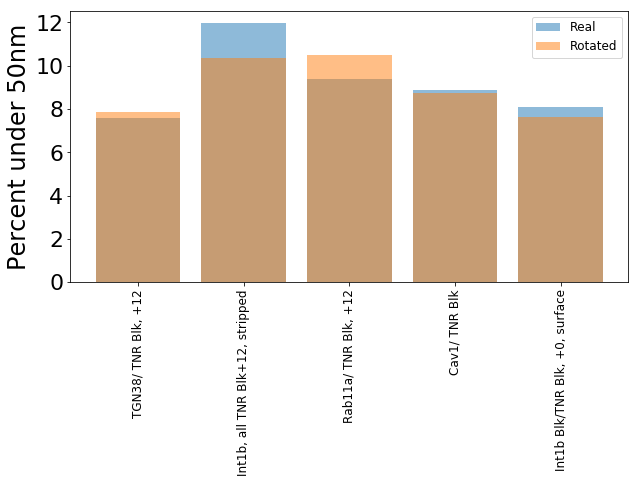

In [667]:
plt.figure(figsize=(10,5))
plt.bar([0,1,2,3,4],val,alpha=.5)
plt.bar([0,1,2,3,4],valrot,alpha=.5)
plt.xticks([0,1,2,3,4],prot,fontsize=12,rotation=90)
plt.yticks(fontsize=22)
plt.ylabel('Percent under 50nm',fontsize=24)
plt.legend(["Real","Rotated"],fontsize=12)

KeyError: 'Distance to endosome'

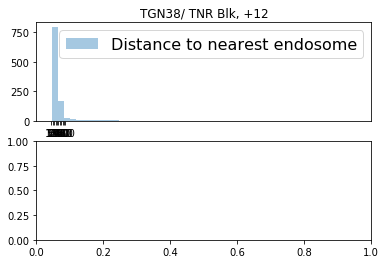

In [312]:
for protein in df_rotated_ecm["Protein"].unique():
    #df2plot=df_ecm[(df_ecm["Treatment"]=="Unblocked Control")&(df_ecm["Protein"]==protein)]
    df2plot=df_rotated_ecm[(df_rotated_ecm["Protein"]==protein)]
    fig=plt.figure()
    fig.add_subplot(211)
    g=sns.distplot(df2plot["distance to nearest endosome centroid [nms]"],label="Distance to nearest endosome",kde=False)
    g.set_xticks(np.linspace(0,500,11))
    #g.set_xlim([-20,700])
    plt.legend(fontsize=16)
    g.set_xlabel('Distance (nms)',fontsize=14)
    plt.title(protein)
    
    fig.add_subplot(212)
    dfcount=df2plot.groupby("Distance to endosome").count()
    smallerthan=dfcount["filename"].unique()[0]
    biggerthan=dfcount["filename"].unique()[1]
    propsmaller=smallerthan/(smallerthan+biggerthan)
    propbigger=biggerthan/(smallerthan+biggerthan)
    dfprops={'Distance':['<100nm','>100nm'],'Percentage':[propsmaller,propbigger]}
    dfprops=pd.DataFrame(dfprops)
    sns.barplot(x="Distance",y="Percentage",data=dfprops)
    plt.text(x=-0.1,y=0.2,s=np.round(propsmaller,3))
    plt.text(x=0.8,y=0.2,s=np.round(propbigger,3))
    
    
    fig.tight_layout()

## Random versus real

KeyError: 'Distance to endosome'

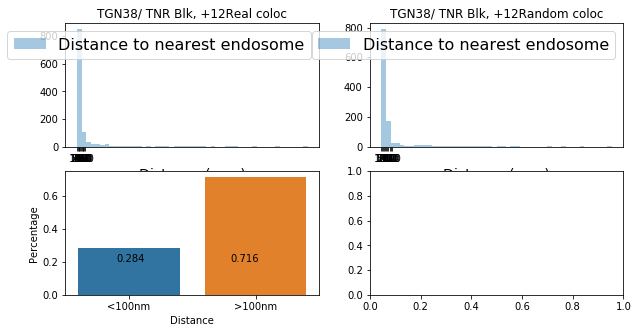

In [313]:
for protein in df_rotated_ecm["Protein"].unique():
    #df2plot=df_ecm[(df_ecm["Treatment"]=="Unblocked Control")&(df_ecm["Protein"]==protein)]
    df2plot=df_ecm[(df_ecm["Protein"]==protein)]
    fig=plt.figure(figsize=(10,5))
    fig.add_subplot(221)
    g=sns.distplot(df2plot["distance to nearest endosome centroid [nms]"],label="Distance to nearest endosome",kde=False)
    g.set_xticks(np.linspace(0,500,11))
    #g.set_xlim([-20,700])
    plt.legend(fontsize=16)
    g.set_xlabel('Distance (nms)',fontsize=14)
    plt.title(protein+'Real coloc')
    
    fig.add_subplot(223)
    dfcount=df2plot.groupby("Distance to endosome").count()
    smallerthan=dfcount["filename"].unique()[0]
    biggerthan=dfcount["filename"].unique()[1]
    propsmaller=smallerthan/(smallerthan+biggerthan)
    propbigger=biggerthan/(smallerthan+biggerthan)
    dfprops={'Distance':['<100nm','>100nm'],'Percentage':[propsmaller,propbigger]}
    dfprops=pd.DataFrame(dfprops)
    sns.barplot(x="Distance",y="Percentage",data=dfprops)
    plt.text(x=-0.1,y=0.2,s=np.round(propsmaller,3))
    plt.text(x=0.8,y=0.2,s=np.round(propbigger,3))
    
    df2plot=df_rotated_ecm[(df_rotated_ecm["Protein"]==protein)]
    
    fig.add_subplot(222)
    g=sns.distplot(df2plot["distance to nearest endosome centroid [nms]"],label="Distance to nearest endosome",kde=False)
    g.set_xticks(np.linspace(0,500,11))
    #g.set_xlim([-20,700])
    plt.legend(fontsize=16)
    g.set_xlabel('Distance (nms)',fontsize=14)
    plt.title(protein+'Random coloc')
    
    fig.add_subplot(224)
    dfcount=df2plot.groupby("Distance to endosome").count()
    smallerthan=dfcount["filename"].unique()[0]
    biggerthan=dfcount["filename"].unique()[1]
    propsmaller=smallerthan/(smallerthan+biggerthan)
    propbigger=biggerthan/(smallerthan+biggerthan)
    dfprops={'Distance':['<100nm','>100nm'],'Percentage':[propsmaller,propbigger]}
    dfprops=pd.DataFrame(dfprops)
    sns.barplot(x="Distance",y="Percentage",data=dfprops)
    plt.text(x=-0.1,y=0.2,s=np.round(propsmaller,3))
    plt.text(x=0.8,y=0.2,s=np.round(propbigger,3))
    
    
    fig.tight_layout()

TGN38/ TNR Blk, +12: 0.12983941500254212
Int1b, all TNR Blk+12, stripped: 0.056496778742440225
Rab11a/ TNR Blk, +12: 0.7828380196515166
Cav1/ TNR Blk: 0.7112704149541974
Int1b Blk/TNR Blk, +0, surface: 0.24258973266365308


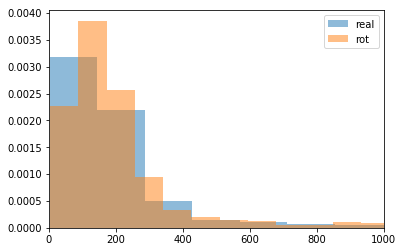

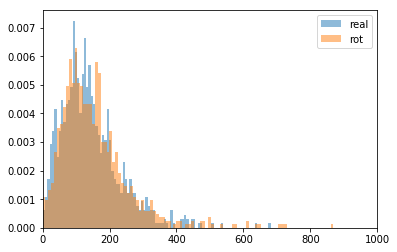

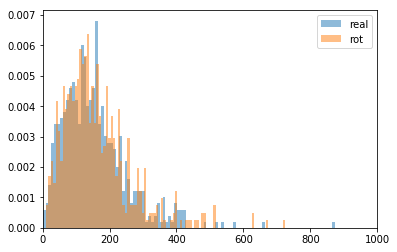

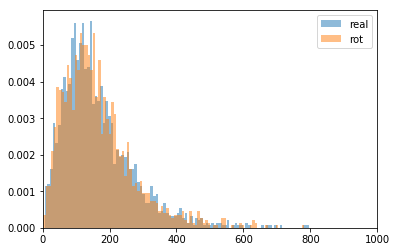

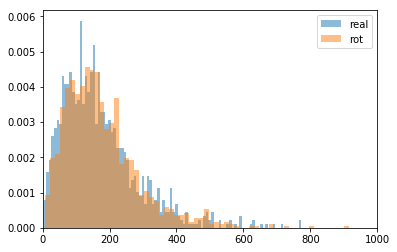

In [339]:
for protein in df_rotated_ecm["Protein"].unique():
    #df2plot=df_ecm[(df_ecm["Treatment"]=="Unblocked Control")&(df_ecm["Protein"]==protein)]
    a=df_ecm[(df_ecm["Protein"]==protein)]["distance to nearest endosome centroid [nms]"]
    b=df_rotated_ecm[(df_rotated_ecm["Protein"]==protein)]["distance to nearest endosome centroid [nms]"]
    
    from scipy import stats
    [k,pval]=stats.ks_2samp(a,b)
    print(protein+': '+str(pval))
    
    plt.figure()
    plt.hist(a,bins=100,density=True,alpha=.5)
    plt.hist(b,bins=100,density=True,alpha=.5)
    plt.xlim(0,1000)
    plt.legend(['real','rot'])

## Find the percent of colocalizing pixels per image versus rotated

In [348]:
df_ecm.groupby("filename")["distance to nearest endosome centroid [nms]"].min()

5696

In [392]:
coloc_perimage={"filename":[],"Protein":[],"percent under 50 real":[],"percent under 50 rotated":[]}

for image in range(0,len(results["filename"])):
    name=results["filename"][image]
    dfreal=df_ecm[df_ecm["filename"]==name]
    if len(dfreal)>0:
        coloc_perimage["filename"].append(name)
        coloc_perimage["Protein"].append(dfreal["Protein"].unique()[0])

        no=dfreal.loc[dfreal["distance to nearest endosome centroid"]<1.5].count()[0]
        total=len(dfreal)
        prop=no/total*100
        coloc_perimage["percent under 50 real"].append(prop)

        dfrot=df_rotated_ecm[df_rotated_ecm["filename"]==name]
        no=dfrot.loc[dfrot["distance to nearest endosome centroid"]<1.5].count()[0]
        total=len(dfrot)
        prop=no/total*100
        coloc_perimage["percent under 50 rotated"].append(prop)
    
        

In [393]:
df_coloc=pd.DataFrame(coloc_perimage)

In [394]:
import scipy
for protein in df_coloc["Protein"].unique():
    df2check=df_coloc[df_coloc["Protein"]==protein]
    a=df2check["percent under 50 real"].values
    b=df2check["percent under 50 rotated"].values
    [t,pval]=scipy.stats.ttest_rel(a, b, axis=0, nan_policy='propagate')
    print(protein+': '+str(pval))

TGN38/ TNR Blk, +12: 0.031663479864839285
Int1b, all TNR Blk+12, stripped: 0.11373478107237063
Rab11a/ TNR Blk, +12: 0.4237078382069406
Cav1/ TNR Blk: 0.7657746665259557
Int1b Blk/TNR Blk, +0, surface: 0.10028582366575002


In [382]:
a.values

array([ 6.52173913,  2.94117647, 13.33333333, 14.70588235,  9.09090909,
        5.55555556, 13.04347826,  5.12820513,  3.07692308,  5.        ,
        3.84615385,  2.63157895, 11.11111111, 10.        ,  0.        ,
       10.        ,  7.14285714, 10.        ,  3.03030303,  4.76190476,
        9.09090909,  7.40740741,  6.81818182, 11.53846154,  8.57142857,
        2.63157895, 14.28571429,  3.84615385,  6.66666667,  3.125     ,
        9.375     ])